# Data Vizualization (Fall 2022) Final Project:
# Forex Trading Optimization Function and Visualization
## Team members: Alexandru Bordanca  &  David Thiriot
## Version date: 28 Nov 2022

In [1]:
# Uncomment pip install if you need to install schemdraw

#!pip install schemdraw[matplotlib]

#%matplotlib inline

#### Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import plotly.express as px
import requests
from tqdm import tqdm
from datetime import datetime
import schemdraw
from schemdraw.flow import *


#### The functionality to read in Forex data is included, to show what we have done for pre-processing of data, but it does NOT need to be run each time.  One can simply read the saved, pre-processed data file that we have included with this code.  
#### No need to run code from this point here until noted again below, then just read in the pre-processed Forex data file.

In [3]:
# Reference for code in this block
# https://www.kaggle.com/code/robikscube/exchange-rate-data-pull-from-imf-org

# Make a dataframe with dates we want to pull
df = pd.DataFrame(pd.date_range("2004-01-01", datetime.today()), columns=["dates"])
df["year"] = df["dates"].dt.year
df["month"] = df["dates"].dt.month
df = df.groupby(["year", "month"])["dates"].min().reset_index()

In [4]:
# Reference for code in this block
# https://www.kaggle.com/code/robikscube/exchange-rate-data-pull-from-imf-org

mts = []
for mydate in tqdm(df["dates"]):
    try:
        url = f"https://www.imf.org/external/np/fin/data/rms_mth.aspx?SelectDate={mydate:%Y-%m-%d}&reportType=REP"
        # Read in from the website
        results = pd.read_html(url)
        results[5].columns = results[5].columns.droplevel(0)
        # Table 1
        tempdf = results[5].set_index("Currency").T
        tempdf.index = pd.to_datetime(tempdf.index.str.replace(",", ", "))
        if results[6].shape == (2, 2):
            mts.append(tempdf)
            continue
        # Table 2
        results[6].columns = results[6].columns.droplevel(0)
        tempdf2 = results[6].set_index("Currency").T
        tempdf2.index = pd.to_datetime(tempdf2.index.str.replace(",", ", "))
        # Concat
        monthall = pd.concat([tempdf, tempdf2])
        mts.append(monthall)
    except:
        print(f"Broke for month {mydate:%Y-%m-%d}")
exchange_data = pd.concat(mts)

100%|█████████████████████████████████████████| 228/228 [10:18<00:00,  2.71s/it]


In [5]:
# Reference for code in this block
# https://www.kaggle.com/code/robikscube/exchange-rate-data-pull-from-imf-org

# Clean up column names
exchange_data.columns = exchange_data.columns.str.lower() \
    .str.replace('.','', regex=False) \
    .str.replace('  (1)','', regex=False) \
    .str.replace('  (2)','', regex=False) \
    .str.replace(' ','_', regex=False)

# These are in to USD format on the IMF website.
usd_curr = ['euro','uk_pound','australian_dollar','botswana_pula','new_zealand_dollar']
for c in usd_curr:
    exchange_data[c] = 1 / exchange_data[c]

    
to_usd_df = pd.DataFrame(index=exchange_data.index)
for currency in exchange_data.columns:
    ex_rate_col = currency.lower().replace('  (1)','').replace(' ','_') \
        .replace('.','') + '_to_usd'
    to_usd_df[ex_rate_col] = 1 / exchange_data[currency]
to_usd_df = to_usd_df.reset_index().rename(columns={'index':'date'})

In [6]:
# Selecting currency pairs and cleaning up Forex data

focus_df_original = to_usd_df[["date", "euro_to_usd", "japanese_yen_to_usd",
                              "uk_pound_to_usd", "australian_dollar_to_usd", "swiss_franc_to_usd"]].copy(deep=True)

focus_df = focus_df_original.copy(deep=True)

print("Before filling the initial NAs\n")
print(focus_df.head(3))
print("\n\n\n")

for exrate in focus_df.columns:    
    if exrate == 'date':
        continue
    firstvalid = focus_df[exrate].first_valid_index()
    if (firstvalid==0): continue
    for initialna in range(firstvalid):
        focus_df.at[initialna, exrate] = focus_df.at[firstvalid, exrate]
    
print("After filling the initial NAs\n")
print(focus_df.head(3))

Before filling the initial NAs

        date  euro_to_usd  japanese_yen_to_usd  uk_pound_to_usd  \
0 2004-01-02       1.2592                  NaN           1.7858   
1 2004-01-05       1.2657             0.009355           1.7996   
2 2004-01-06       1.2756             0.009412           1.8209   

   australian_dollar_to_usd  swiss_franc_to_usd  
0                    0.7527                 NaN  
1                    0.7630            0.812876  
2                    0.7668            0.813008  




After filling the initial NAs

        date  euro_to_usd  japanese_yen_to_usd  uk_pound_to_usd  \
0 2004-01-02       1.2592             0.009355           1.7858   
1 2004-01-05       1.2657             0.009355           1.7996   
2 2004-01-06       1.2756             0.009412           1.8209   

   australian_dollar_to_usd  swiss_franc_to_usd  
0                    0.7527            0.812876  
1                    0.7630            0.812876  
2                    0.7668            0.8130

In [7]:
# Now, use interpolate to fill in the NA gaps.  
# https://pandas.pydata.org/pandas-docs/version/0.24/reference/api/pandas.DataFrame.interpolate.html

print("Number of NAs after interpolating")

for exrate in focus_df.columns:    
    if exrate == 'date':
        continue
    focus_df[exrate].interpolate(inplace=True)

focus_df.isna().sum()

# Now, all the NAs have been addressed in a reasonable manner

Number of NAs after interpolating


date                        0
euro_to_usd                 0
japanese_yen_to_usd         0
uk_pound_to_usd             0
australian_dollar_to_usd    0
swiss_franc_to_usd          0
dtype: int64

In [8]:
# Pad the forex rate data for the last 2 months of 2003, with false, constant data
# Doing this to set a clear baseline for looking for crossings of exponentially weighted means
# The 2 months of false data uses the same rate as on January 1, 2004
# I don't know if this run in period is necessary or not, but it won't hurt the analysis and might help (21Nov2022 DT)

initial_pad_false_data = pd.DataFrame(columns=focus_df.columns)
initial_pad_false_data['date'] = pd.date_range(start='2003-11-01', end='2003-12-31')
initial_pad_false_data['euro_to_usd'] = focus_df['euro_to_usd'][0] 
initial_pad_false_data['japanese_yen_to_usd'] = focus_df['japanese_yen_to_usd'][0]  
initial_pad_false_data['uk_pound_to_usd'] = focus_df['uk_pound_to_usd'][0]  
initial_pad_false_data['australian_dollar_to_usd'] = focus_df['australian_dollar_to_usd'][0]  
initial_pad_false_data['swiss_franc_to_usd'] = focus_df['swiss_franc_to_usd'][0]  

focus_df = pd.concat([initial_pad_false_data, focus_df], ignore_index=True)

# And save to .csv file.  Has timeframe 2004-01-01 to mid November 2022

# Rather than loading in the data through the code above, we can simply read this .csv file

focus_df.to_csv("forex_data.csv")

#### This is where to start running code again.  The next block will read in the saved, pre-processed Forex data file.

In [9]:
# Read in the saved Forex data

forex_rates = pd.read_csv("forex_data.csv", header=0, index_col=0)
forex_rates['date'] = pd.to_datetime(forex_rates['date'], format="%Y-%m-%d")
#print(forex_rates.dtypes)
forex_rates

,date,euro_to_usd,japanese_yen_to_usd,uk_pound_to_usd,australian_dollar_to_usd,swiss_franc_to_usd
0,2003-11-01,1.2592,0.009355,1.78580,0.7527,0.812876
1,2003-11-02,1.2592,0.009355,1.78580,0.7527,0.812876
2,2003-11-03,1.2592,0.009355,1.78580,0.7527,0.812876
3,2003-11-04,1.2592,0.009355,1.78580,0.7527,0.812876
4,2003-11-05,1.2592,0.009355,1.78580,0.7527,0.812876
...,...,...,...,...,...,...
4831,2022-11-29,1.0366,0.007202,1.20235,0.6706,1.052909
4832,2022-11-30,1.0376,0.007205,1.20110,0.6698,1.053020
4833,2022-12-01,1.0454,0.007339,1.21665,0.6809,1.057194
4834,2022-12-02,1.0538,0.007380,1.22780,0.6813,1.071409


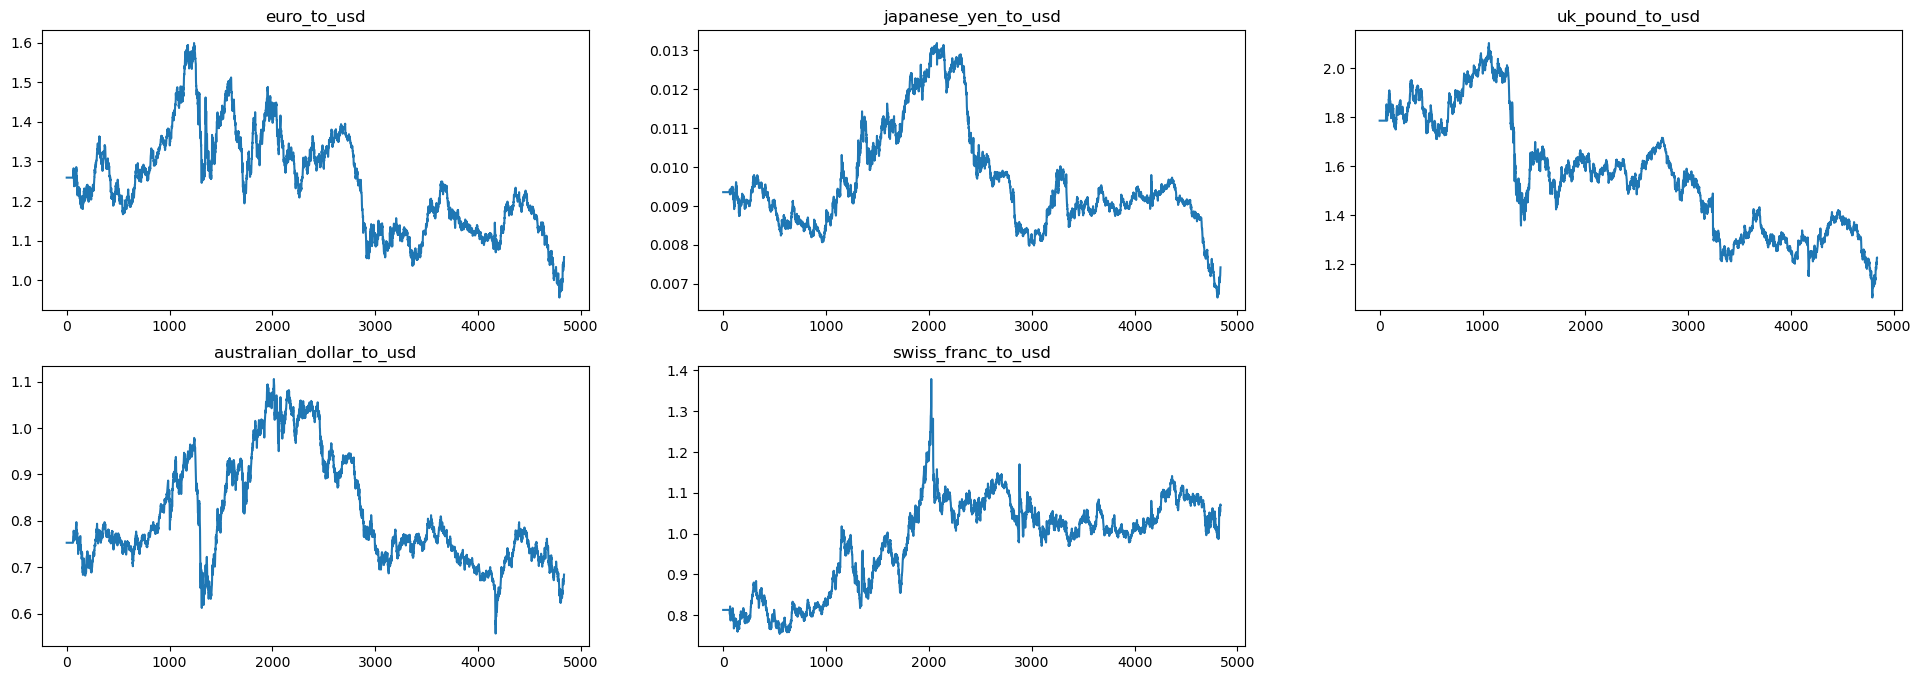

In [10]:
currencies = ['euro_to_usd','japanese_yen_to_usd','uk_pound_to_usd','australian_dollar_to_usd','swiss_franc_to_usd']


fig = plt.figure(figsize=(24,8))
for i in range(len(currencies)):
    plt.subplot(231+i)
    plt.plot(forex_rates[currencies[i]])
    plt.title(currencies[i])

plt.savefig('currency_plots.png')

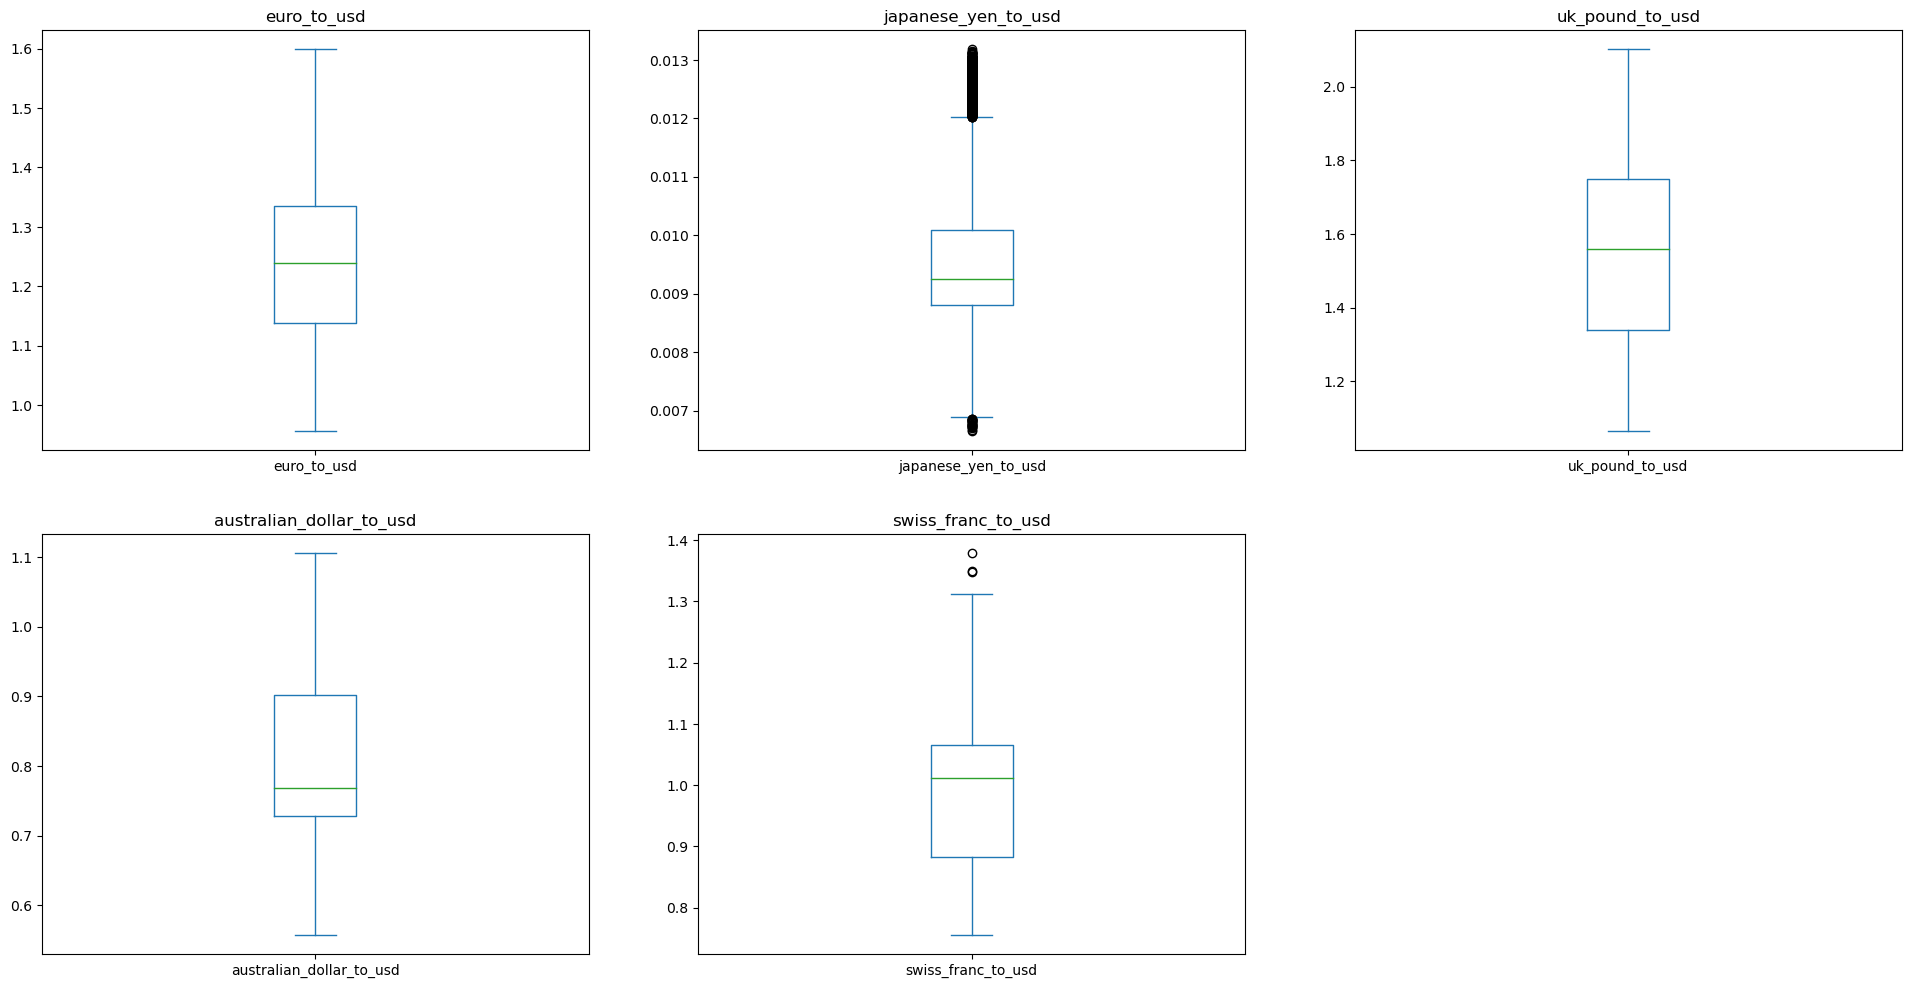

In [11]:
fig = plt.figure(figsize=(24,12))

for i in range(len(currencies)):
    plt.subplot(231+i)
    forex_rates[currencies[i]].plot(kind='box')
    plt.title(currencies[i])
plt.savefig('currency_box.png')

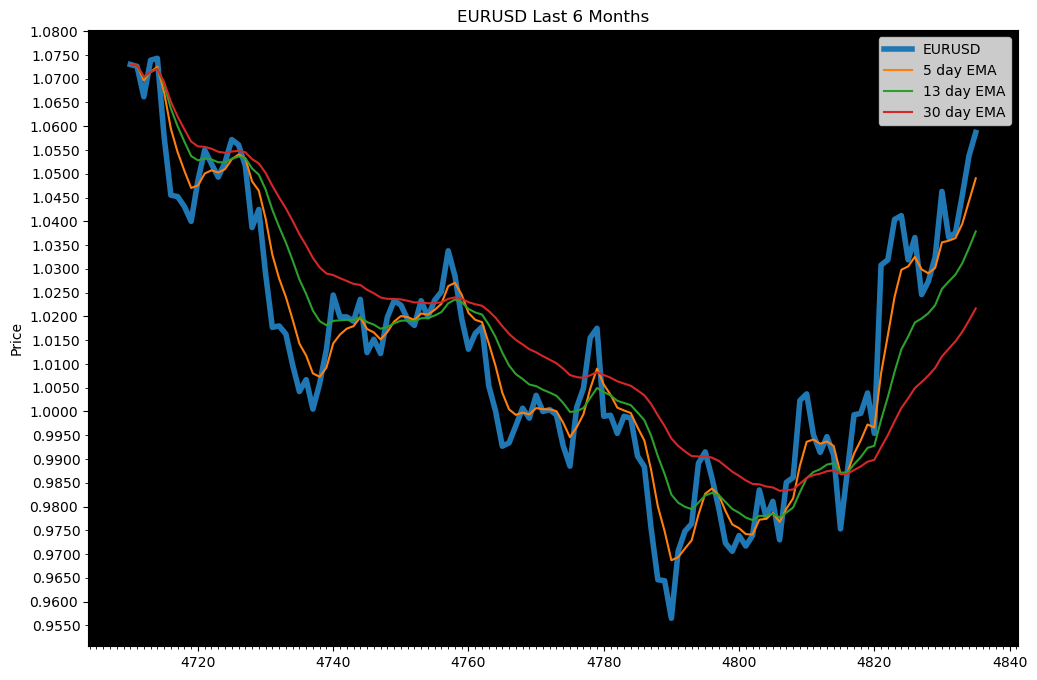

In [12]:
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
fig = plt.figure(figsize=(12,8))
eurusd = pd.DataFrame()
eurusd['rate'] = forex_rates['euro_to_usd']
ax = eurusd['rate'][-126:].plot(lw=4,label='EURUSD')
[eur_5d_ema,eur_13d_ema,eur_30_ema]=[eurusd['rate'][-126:].ewm(span=i).mean() for i in [5,13,30]]

ema_s = [eur_5d_ema,eur_13d_ema,eur_30_ema]
num_list =[5,13,30]
for i in num_list:
    ema_s[num_list.index(i)].plot(ax=ax,label = '{} day EMA'.format(i))
plt.legend()
plt.ylabel('Price')
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.yaxis.set_minor_formatter(FormatStrFormatter('%.4f'))

plt.title('EURUSD Last 6 Months')
ax.set_facecolor('black')
plt.savefig('EURUSD6MO.png')

In [14]:
!pip install dataframe-image
import dataframe_image as dfi
dfi.export(forex_rates.head(10),'table.png')

[1205/160254.331221:INFO:headless_shell.cc(657)] Written to file /var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/tmpv_ij4s_d/temp.png.


**Now we try to come up with some trades based off EMA intersections, trying the 5, 13, and 30**

In [15]:
[eur_5d_ema,eur_13d_ema,eur_30_ema]=[eurusd['rate'].ewm(span=i).mean() for i in [5,13,30]]


eurusd['5d_ema'] = eur_5d_ema
eurusd['13d_ema'] = eur_13d_ema
eurusd['30d_ema'] = eur_30_ema
eurusd.head()

,rate,5d_ema,13d_ema,30d_ema
0,1.2592,1.2592,1.2592,1.2592
1,1.2592,1.2592,1.2592,1.2592
2,1.2592,1.2592,1.2592,1.2592
3,1.2592,1.2592,1.2592,1.2592
4,1.2592,1.2592,1.2592,1.2592


In [16]:
#try different strategies rate crossing with 5, 5 crossing with 13, 13 crossing with 30
_rx5eur = eurusd[['rate','5d_ema']].copy()
_5x13eur = eurusd[['rate','5d_ema','13d_ema']].copy()
_13x30eur = eurusd[['rate','13d_ema','30d_ema']].copy()
_rx5eur['Signal'] = 0.0 
_5x13eur['Signal'] = 0.0 
_13x30eur['Signal'] = 0.0 

_rx5eur['Signal'] = np.where(_rx5eur['rate'] > _rx5eur['5d_ema'], 1.0, 0.0)
_5x13eur['Signal'] = np.where(_5x13eur['5d_ema'] > _5x13eur['13d_ema'], 1.0, 0.0)
_13x30eur['Signal'] = np.where(_13x30eur['13d_ema'] > _13x30eur['30d_ema'], 1.0, 0.0)

_rx5eur['Position'] = _rx5eur['Signal'].diff()
_5x13eur['Position'] = _5x13eur['Signal'].diff()
_13x30eur['Position'] = _13x30eur['Signal'].diff()

**Position will now indicate when to buy and sell
When it switches from 0 to 1, it's a buy as our Signal column indicates that the faster moving EMA has crossed the slower one. And vice versa, from 0 to -1**

In [17]:
_rx5eur.head(40)

,rate,5d_ema,Signal,Position
0,1.2592,1.2592,0.0,NaN
1,1.2592,1.2592,0.0,0.0
2,1.2592,1.2592,0.0,0.0
3,1.2592,1.2592,0.0,0.0
4,1.2592,1.2592,0.0,0.0
5,1.2592,1.2592,0.0,0.0
6,1.2592,1.2592,0.0,0.0
7,1.2592,1.2592,0.0,0.0
8,1.2592,1.2592,0.0,0.0
9,1.2592,1.2592,0.0,0.0


In [18]:
_5x13eur = _5x13eur.tail(100)

**Now we try to come up with some visualizations marking our entry and exit points**

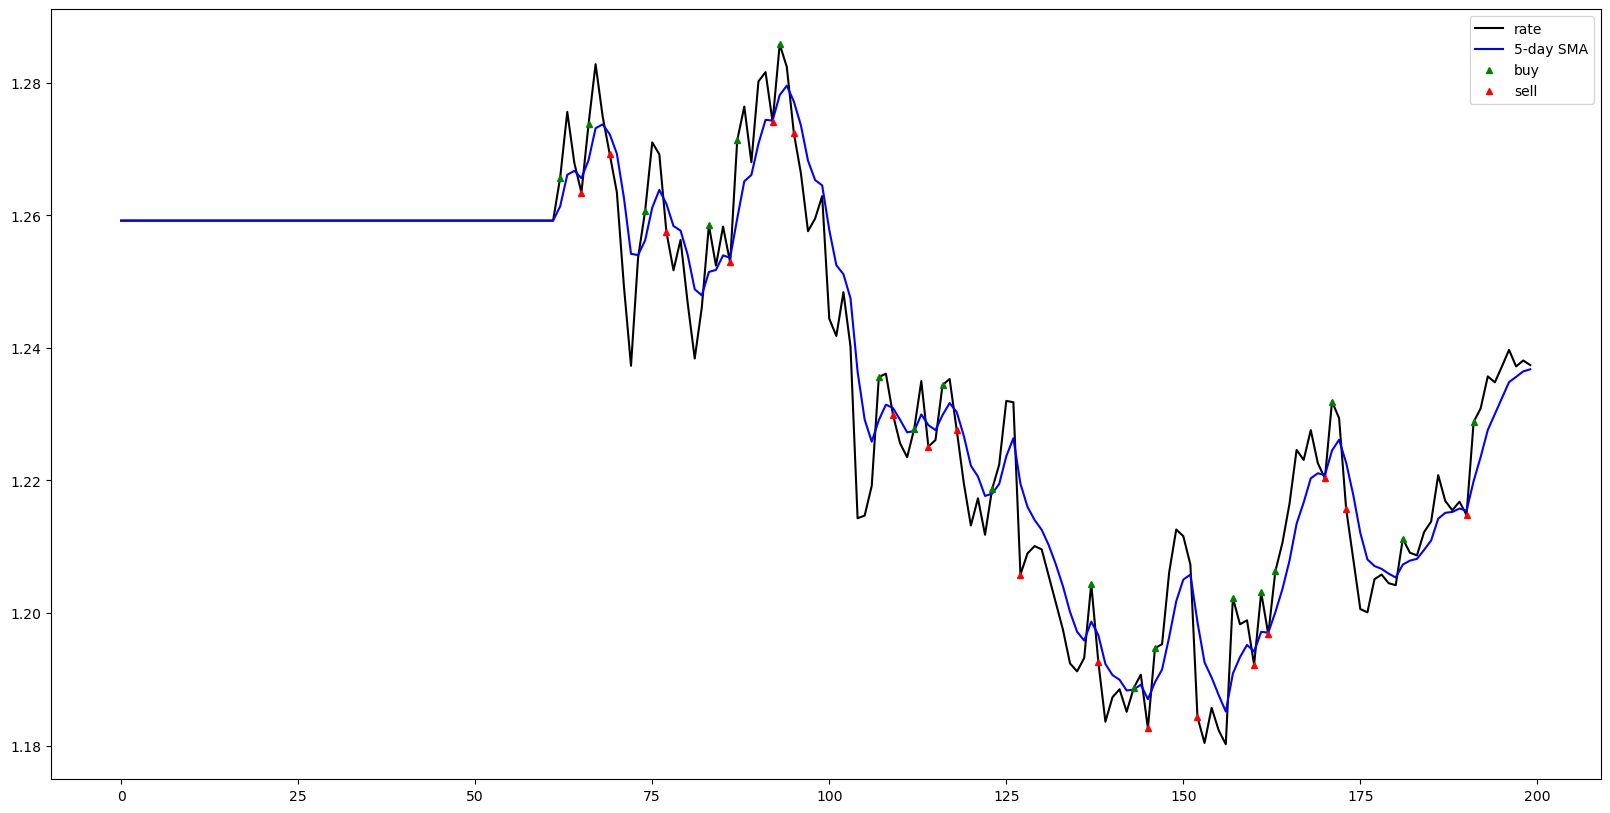

In [19]:
plt.figure(figsize = (20,10))
_rx5eur = _rx5eur.head(200)
_rx5eur['rate'].plot(color = 'k', label= 'rate') 
_rx5eur['5d_ema'].plot(color = 'b', label = '5-day SMA') 
# plot ‘buy’ signals
plt.plot(_rx5eur[_rx5eur['Position'] == 1].index, 
        _rx5eur['rate'][_rx5eur['Position'] == 1], 
         '^', markersize = 5, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(_rx5eur[_rx5eur['Position'] == -1].index, 
        _rx5eur['rate'][_rx5eur['Position'] == -1], 
         '^', markersize = 5, color = 'r', label = 'sell')


plt.legend()

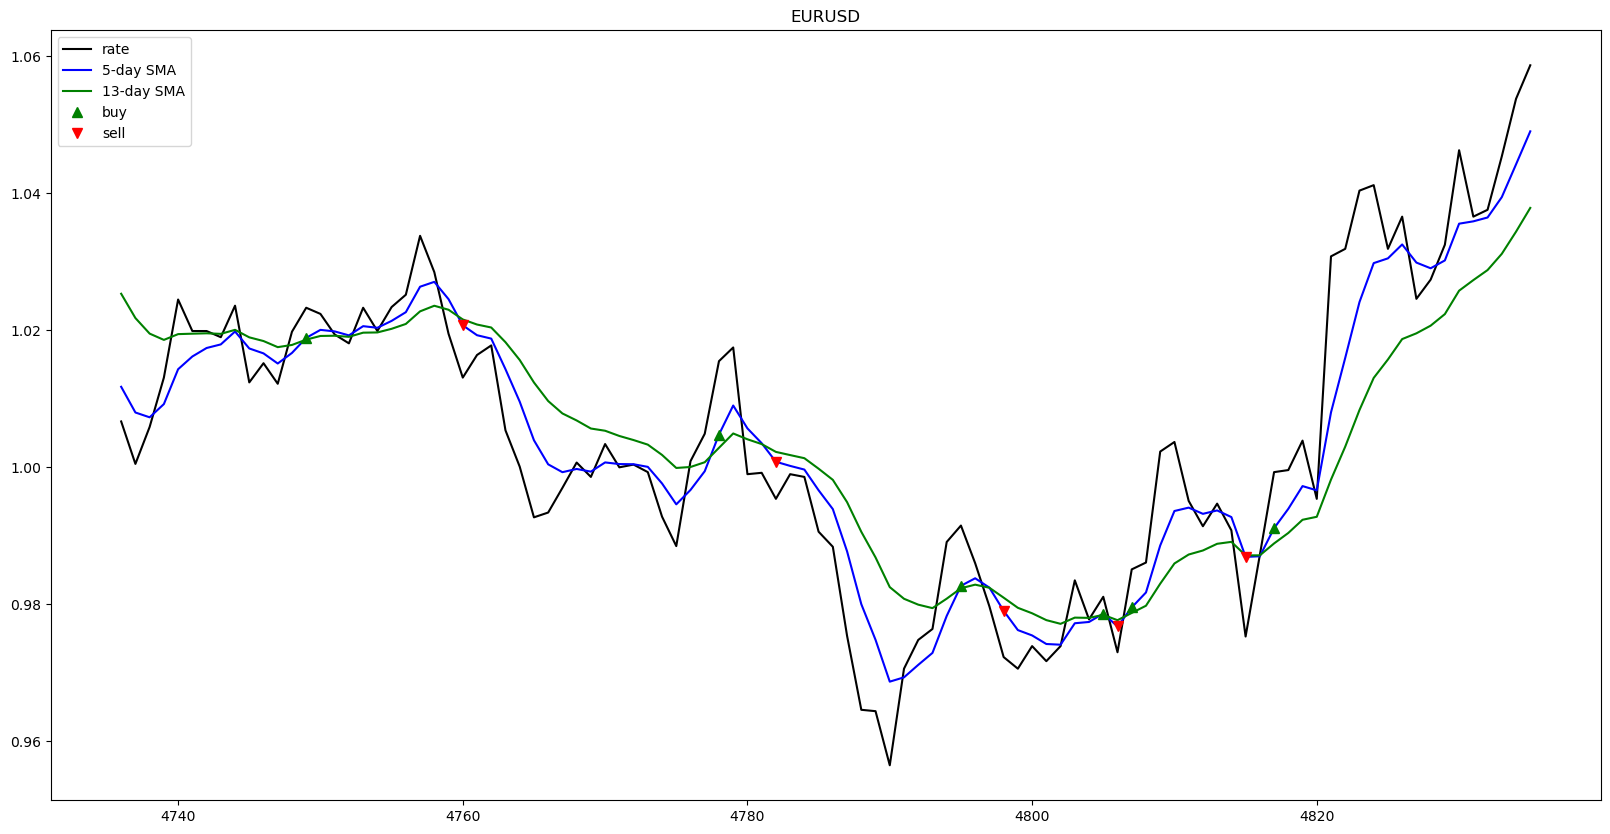

In [20]:
plt.figure(figsize = (20,10))
_5x13eur['rate'].plot(color = 'k', label= 'rate') 
_5x13eur['5d_ema'].plot(color = 'b', label = '5-day SMA') 
_5x13eur['13d_ema'].plot(color = 'g', label = '13-day SMA') 


# plot ‘buy’ signals
plt.plot(_5x13eur[_5x13eur['Position'] == 1].index, 
        _5x13eur['5d_ema'][_5x13eur['Position'] == 1], 
         '^', markersize = 7, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(_5x13eur[_5x13eur['Position'] == -1].index, 
        _5x13eur['5d_ema'][_5x13eur['Position'] == -1], 
         'v', markersize = 7, color = 'r', label = 'sell')


plt.legend()
plt.title('EURUSD')
plt.savefig('ema_viz.png')

In [21]:
trades_eur_5x13 = _5x13eur.loc[_5x13eur['Position']!=0]
trades_eur_5x13

,rate,5d_ema,13d_ema,Signal,Position
4749,1.0233,1.018903,1.018645,1.0,1.0
4760,1.0131,1.020735,1.021591,0.0,-1.0
4778,1.0155,1.004788,1.002852,1.0,1.0
4782,0.9954,1.000815,1.002254,0.0,-1.0
4795,0.9915,0.982703,0.982348,1.0,1.0
4798,0.9723,0.979056,0.980972,0.0,-1.0
4805,0.9811,0.978649,0.978461,1.0,1.0
4806,0.9730,0.976766,0.977681,0.0,-1.0
4807,0.9851,0.979544,0.978741,1.0,1.0
4815,0.9753,0.986925,0.987143,0.0,-1.0


In [22]:
trades_eur_5x13['rate_change'] = trades_eur_5x13['rate'].diff()
trades_eur_5x13

/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/ipykernel_73970/219635391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_eur_5x13['rate_change'] = trades_eur_5x13['rate'].diff()


,rate,5d_ema,13d_ema,Signal,Position,rate_change
4749,1.0233,1.018903,1.018645,1.0,1.0,NaN
4760,1.0131,1.020735,1.021591,0.0,-1.0,-0.0102
4778,1.0155,1.004788,1.002852,1.0,1.0,0.0024
4782,0.9954,1.000815,1.002254,0.0,-1.0,-0.0201
4795,0.9915,0.982703,0.982348,1.0,1.0,-0.0039
4798,0.9723,0.979056,0.980972,0.0,-1.0,-0.0192
4805,0.9811,0.978649,0.978461,1.0,1.0,0.0088
4806,0.9730,0.976766,0.977681,0.0,-1.0,-0.0081
4807,0.9851,0.979544,0.978741,1.0,1.0,0.0121
4815,0.9753,0.986925,0.987143,0.0,-1.0,-0.0098


In [23]:
_5x13eur = eurusd[['rate','5d_ema','13d_ema']].copy()
_5x13eur['Signal'] = 0.0 
_5x13eur['Signal'] = np.where(_5x13eur['5d_ema'] > _5x13eur['13d_ema'], 1.0, 0.0)

_5x13eur['Position'] = _5x13eur['Signal'].diff()
trades_eur_5x13 = _5x13eur.loc[_5x13eur['Position']!=0]
trades_eur_5x13['rate_change'] = trades_eur_5x13['rate'].diff()
trades_eur_5x13


/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/ipykernel_73970/2801677307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_eur_5x13['rate_change'] = trades_eur_5x13['rate'].diff()


,rate,5d_ema,13d_ema,Signal,Position,rate_change
0,1.2592,1.259200,1.259200,0.0,NaN,NaN
62,1.2657,1.261367,1.260129,1.0,1.0,0.0065
71,1.2493,1.262640,1.265127,0.0,-1.0,-0.0164
76,1.2692,1.263836,1.262781,1.0,1.0,0.0199
77,1.2575,1.261724,1.262026,0.0,-1.0,-0.0117
...,...,...,...,...,...,...
4805,0.9811,0.978649,0.978461,1.0,1.0,0.0088
4806,0.9730,0.976766,0.977681,0.0,-1.0,-0.0081
4807,0.9851,0.979544,0.978741,1.0,1.0,0.0121
4815,0.9753,0.986925,0.987143,0.0,-1.0,-0.0098


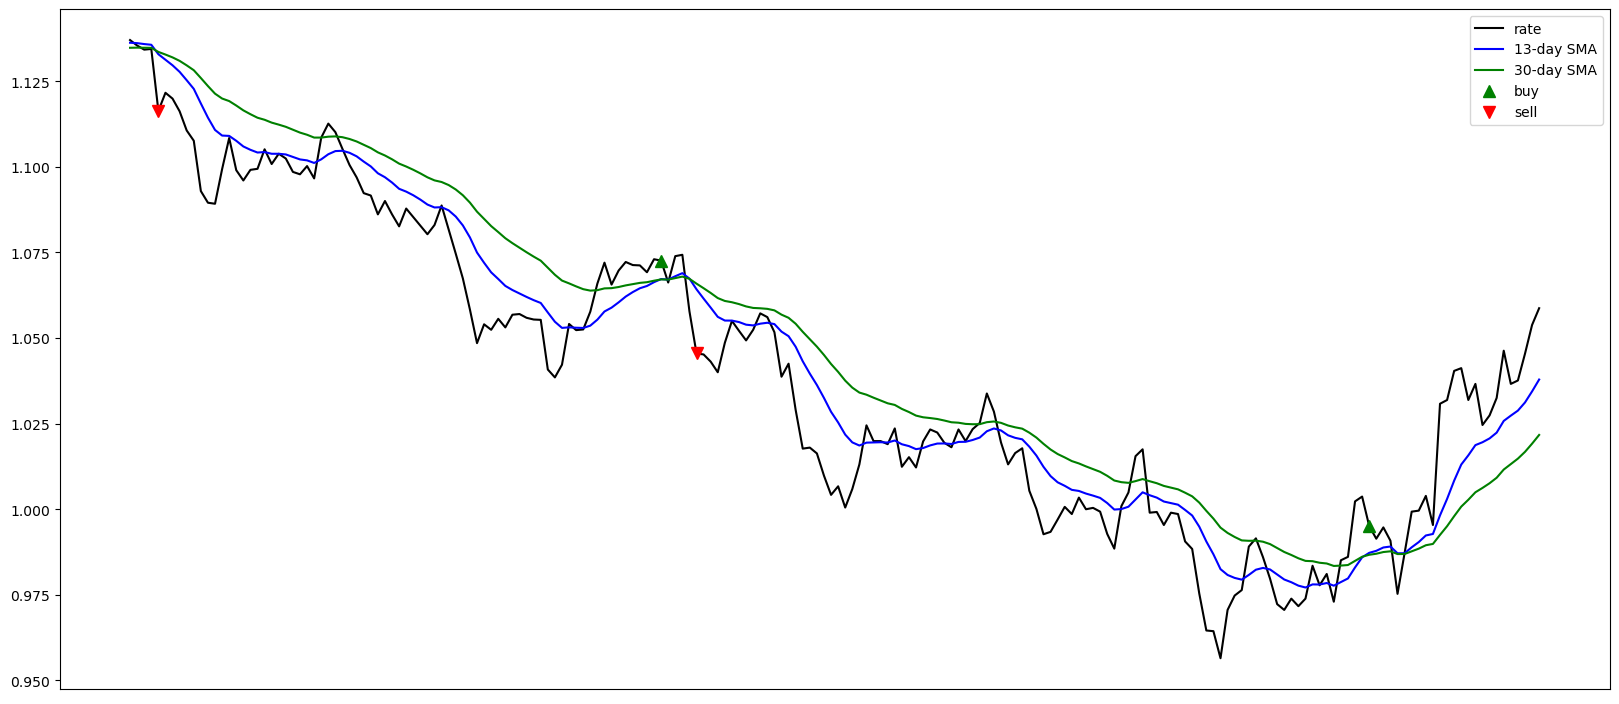

In [24]:
_13x30eur = _13x30eur.tail(200)
_13x30eur.index = pd.to_datetime(_13x30eur.index)
plt.figure(figsize = (20,10))
_13x30eur['rate'].plot(color = 'k', label= 'rate') 
_13x30eur['13d_ema'].plot(color = 'b', label = '13-day SMA') 
_13x30eur['30d_ema'].plot(color = 'g', label = '30-day SMA') 


# plot ‘buy’ signals
plt.plot(_13x30eur[_13x30eur['Position'] == 1].index, 
        _13x30eur['rate'][_13x30eur['Position'] == 1], 
         '^', markersize = 8, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(_13x30eur[_13x30eur['Position'] == -1].index, 
        _13x30eur['rate'][_13x30eur['Position'] == -1], 
         'v', markersize = 8, color = 'r', label = 'sell')


plt.legend()

In [25]:
#try different strategies rate crossing with 5, 5 crossing with 13, 13 crossing with 30
_rx5eur = eurusd[['rate','5d_ema']].copy()
_5x13eur = eurusd[['rate','5d_ema','13d_ema']].copy()
_13x30eur = eurusd[['rate','13d_ema','30d_ema']].copy()
_rx5eur['Signal'] = 0.0 
_5x13eur['Signal'] = 0.0 
_13x30eur['Signal'] = 0.0 

_rx5eur['Signal'] = np.where(_rx5eur['rate'] > _rx5eur['5d_ema'], 1.0, 0.0)
_5x13eur['Signal'] = np.where(_5x13eur['5d_ema'] > _5x13eur['13d_ema'], 1.0, 0.0)
_13x30eur['Signal'] = np.where(_13x30eur['13d_ema'] > _13x30eur['30d_ema'], 1.0, 0.0)

_rx5eur['Position'] = _rx5eur['Signal'].diff()
_5x13eur['Position'] = _5x13eur['Signal'].diff()
_13x30eur['Position'] = _13x30eur['Signal'].diff()

In [26]:
_13x30eur = eurusd[['rate','13d_ema','30d_ema']].copy()
_13x30eur['Signal'] = 0.0 
_13x30eur['Signal'] = np.where(_13x30eur['13d_ema'] > _13x30eur['30d_ema'], 1.0, 0.0)

_13x30eur['Position'] = _13x30eur['Signal'].diff()
trades_eur_13x30 = _13x30eur.loc[_13x30eur['Position']!=0]
trades_eur_13x30['rate_change'] = trades_eur_13x30['rate'].diff()
trades_eur_13x30

/var/folders/sx/889jdz09109dzlhy65xnx_6m0000gn/T/ipykernel_73970/1962302625.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_eur_13x30['rate_change'] = trades_eur_13x30['rate'].diff()


,rate,13d_ema,30d_ema,Signal,Position,rate_change
0,1.2592,1.259200,1.259200,0.0,NaN,NaN
62,1.2657,1.260129,1.259626,1.0,1.0,0.0065
72,1.2373,1.261152,1.261769,0.0,-1.0,-0.0284
76,1.2692,1.262781,1.262317,1.0,1.0,0.0319
78,1.2517,1.260551,1.261336,0.0,-1.0,-0.0175
...,...,...,...,...,...,...
4629,1.1408,1.133325,1.132731,1.0,1.0,0.0104
4640,1.1163,1.132862,1.133535,0.0,-1.0,-0.0245
4711,1.0726,1.067207,1.067109,1.0,1.0,-0.0437
4716,1.0455,1.064223,1.065873,0.0,-1.0,-0.0271


**From what we see in the visualizations and tables above, it doesn't look too promising so we need to refine our appraoch. The two cells below help give us an indication that since there is a sufficient difference of pip change between our supposed entry and exit points, we have some promise in that we don't need to cap our profitability by implementing a fixed take profit.**

In [27]:
trades_eur_13x30.rate_change.abs().mean()

0.026393333333333335

In [28]:
trades_eur_5x13.rate_change.abs().mean()

0.01584477747502271

In [29]:
_13x30_trade_table = pd.DataFrame()
_13x30_trade_table['rate'] = trades_eur_13x30['rate']
pos_dict = {
    -1: 'Sell',
    1: 'Buy'
}
_13x30_trade_table['Action'] = trades_eur_13x30['Position'].map(pos_dict)

In [30]:
_13x30_trade_table

,rate,Action
0,1.2592,NaN
62,1.2657,Buy
72,1.2373,Sell
76,1.2692,Buy
78,1.2517,Sell
...,...,...
4629,1.1408,Buy
4640,1.1163,Sell
4711,1.0726,Buy
4716,1.0455,Sell


**Now we can create automated functions to generate these tables to continue to brute force test our model against other currencies.**

In [31]:
def ema_generator(currency,*ema_spans):
    currency_ema_df = pd.DataFrame()
    currency_ema_df['rate'] = forex_rates['{}'.format(currency)]
    for ema_span in ema_spans:
        currency_ema_df['{}d_ema'.format(ema_span)] = currency_ema_df['rate'].ewm(span=ema_span).mean()
    
    return currency_ema_df

In [32]:
def trade_generator(currency_ema_df):
    
    trade_table = currency_ema_df.copy()
    trade_table['Signal'] = 0.0
    trade_table['Signal'] = np.where(currency_ema_df.iloc[:,-2] > currency_ema_df.iloc[:,-1],1.0,0.0)
    trade_table['Position'] = trade_table['Signal'].diff()
    
    
    pos_dict = {
    -1: 'Sell',
    1: 'Buy'
    }
    trade_table['Action'] = trade_table['Position'].map(pos_dict)
    trade_table.dropna(how='any',inplace=True)
    return trade_table

In [33]:
x = ema_generator('euro_to_usd',13,30)
y = trade_generator(x.head(200))
y[['rate','Action']]

,rate,Action
62,1.2657,Buy
72,1.2373,Sell
76,1.2692,Buy
78,1.2517,Sell
88,1.2764,Buy
100,1.2444,Sell
165,1.2165,Buy


In [34]:
trade_generator(ema_generator('japanese_yen_to_usd',5,13))

,rate,5d_ema,13d_ema,Signal,Position,Action
63,0.009412,0.009374,0.009363,1.0,1.0,Buy
66,0.009298,0.009365,0.009366,0.0,-1.0,Sell
68,0.009387,0.009367,0.009366,1.0,1.0,Buy
73,0.009302,0.009366,0.009373,0.0,-1.0,Sell
76,0.009416,0.009375,0.009373,1.0,1.0,Buy
...,...,...,...,...,...,...
4745,0.007329,0.007292,0.007291,1.0,1.0,Buy
4763,0.007338,0.007415,0.007434,0.0,-1.0,Sell
4811,0.006821,0.006790,0.006788,1.0,1.0,Buy
4812,0.006746,0.006776,0.006782,0.0,-1.0,Sell


In [35]:
trade_generator(ema_generator('australian_dollar_to_usd',5,13))

,rate,5d_ema,13d_ema,Signal,Position,Action
62,0.7630,0.756133,0.754172,1.0,1.0,Buy
73,0.7575,0.764585,0.765796,0.0,-1.0,Sell
75,0.7732,0.768616,0.767344,1.0,1.0,Buy
82,0.7615,0.767055,0.768563,0.0,-1.0,Sell
87,0.7762,0.767605,0.767143,1.0,1.0,Buy
...,...,...,...,...,...,...
4741,0.6912,0.684208,0.683628,1.0,1.0,Buy
4763,0.6914,0.697303,0.698512,0.0,-1.0,Sell
4810,0.6511,0.639774,0.637159,1.0,1.0,Buy
4816,0.6348,0.638397,0.638694,0.0,-1.0,Sell


In [36]:
trade_generator(ema_generator('swiss_franc_to_usd',5,13))

,rate,5d_ema,13d_ema,Signal,Position,Action
63,0.813008,0.812920,0.812895,1.0,1.0,Buy
64,0.807363,0.811068,0.812105,0.0,-1.0,Sell
67,0.821558,0.813866,0.812624,1.0,1.0,Buy
70,0.807754,0.811610,0.812109,0.0,-1.0,Sell
76,0.812876,0.806833,0.806804,1.0,1.0,Buy
...,...,...,...,...,...,...
4810,1.009846,1.004135,1.003568,1.0,1.0,Buy
4812,1.000150,1.002948,1.003227,0.0,-1.0,Sell
4813,1.006492,1.004130,1.003694,1.0,1.0,Buy
4815,0.986534,0.998205,1.001263,0.0,-1.0,Sell


#### The next code block is the function 'ForexTradeFinder'.  Given a pandas dataframe with 2 columns (date and corresponding exchange rate), it works sequentially through the data to apply logic to determine whether a trade should start, continue, or stop on each day.  It calculates local support lines to make this decision, and also makes use of an exponential weighted mean as a support line (to enforce the logic 'buy low, sell high').  It does not use crossing points of different exponential weighted mean lines to make the decision.  It compares the daily rate with the values of local support lines and the exponential weighted mean support line to make the action decisions.  


In [37]:
# Warning, this function uses the dataframe.iat command a lot.  I found it to work reliably.  The danger is
# that any change to the code below must not alter the position of many columns in the dataframes created,
# as those positions are relied upon for the .iat command.

def ForexTradeFinder(a_dataframe, CurrencyName, StartPlotDate, EndPlotDate, MinForTrend = 2, EWM_span=13):

    PracticeTrend = pd.DataFrame(columns=['date', 'd-2_rate', 'd-1_rate', 'today_rate', 'd-1_local_type', 
                                      'trend_on_off', 'trend_num', 'trend_dir', 'trend_start', 'trend_end', 
                                      'trend_highest_min', 'trend_highest_max', 'trend_lowest_min',
                                      'trend_lowest_max', 'enter_trend_rate', 'exit_trend_rate', 
                                      'enter_trend_action', 'exit_trend_action', 'trend_factor_gainloss',
                                      'trend_duration', 'ewm5', 'ewm13', 'ewm30', 'ewm_order', 
                                      'enter_ewm_order', 'exit_ewm_order', 'ewm_param_span',
                                     ])   

    PracticeTrend['date'] = pd.to_datetime(a_dataframe['date'], format='%Y-%m-%d')
    PracticeTrend['today_rate'] = a_dataframe.iloc[:,1]
    PracticeTrend['d-1_rate'] = PracticeTrend.today_rate.shift(1)
    PracticeTrend['d-2_rate'] = PracticeTrend.today_rate.shift(2)
    PracticeTrend['trend_on_off'] = 'off'
    PracticeTrend['ewm5'] = PracticeTrend['today_rate'].ewm(span=5).mean()
    PracticeTrend['ewm13'] = PracticeTrend['today_rate'].ewm(span=13).mean()
    PracticeTrend['ewm30'] = PracticeTrend['today_rate'].ewm(span=30).mean()
    PracticeTrend['ewm_param_span'] = PracticeTrend['today_rate'].ewm(span=EWM_span).mean()
    ## Note that in the end, I did not use logic related to ewm5, ewm13, ewm30, or the order of these values
    ## I tried that, and it didn't seem to work as well or easily as simply using one ewm with a tunable span
    ## as a single support line.  But I have left in some of this code, and simply don't use it in the final function.
    for counter in range(len(PracticeTrend['date'])):
        ewm_order = np.argsort(PracticeTrend.loc[counter, ['ewm5', 'ewm13', 'ewm30']])
        if(np.all(ewm_order==[0,1,2])): PracticeTrend.iat[counter, 23] = 1  #This order is ewm5 < emw13 < emw30
        if(np.all(ewm_order==[0,2,1])): PracticeTrend.iat[counter, 23] = 2  #This order is ewm5 < emw30 < emw13
        if(np.all(ewm_order==[1,2,0])): PracticeTrend.iat[counter, 23] = 3  #This order is ewm13 < emw30 < emw5
        if(np.all(ewm_order==[1,0,2])): PracticeTrend.iat[counter, 23] = 4  #This order is ewm13 < emw5 < emw30
        if(np.all(ewm_order==[2,0,1])): PracticeTrend.iat[counter, 23] = 5  #This order is ewm30 < emw5 < emw13
        if(np.all(ewm_order==[2,1,0])): PracticeTrend.iat[counter, 23] = 6  #This order is ewm30 < emw13 < emw5
        
    for counter in range(len(PracticeTrend['date'])):
    
    # 'date' = col 0 ;  'd-2_rate' = col 1 ;  'd-1_rate' = col 2 ;  today_rate = col3 ;  d-1_local_type = col4
    
        if((PracticeTrend.iat[counter, 2]>PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 3]>PracticeTrend.iat[counter, 2])):
            PracticeTrend.iat[counter, 4] = "up3"
            continue
        if((PracticeTrend.iat[counter, 2]<PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 3]<PracticeTrend.iat[counter, 2])):
            PracticeTrend.iat[counter, 4] = "down3"
            continue
        if((PracticeTrend.iat[counter, 2]>PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]>PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "lmax"
            continue
        if((PracticeTrend.iat[counter, 2]<PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]<PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "lmin"
            continue
        if((PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]<PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "equalup"
            continue
        if((PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]>PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "equaldown"
            continue
        if((PracticeTrend.iat[counter, 2]>PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "upequal"
            continue
        if((PracticeTrend.iat[counter, 2]<PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "downequal"
            continue
        if((PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 1])&
           (PracticeTrend.iat[counter, 2]==PracticeTrend.iat[counter, 3])):
            PracticeTrend.iat[counter, 4] = "equal3"
            continue
        
    for counter in np.arange(2, len(PracticeTrend['date'])-1):
        if((PracticeTrend.iat[counter-1, 4]=="upequal")&(PracticeTrend.iat[counter+1, 4]=="equaldown")&(PracticeTrend.iat[counter, 4]=='equal3')):
            PracticeTrend.iat[counter, 4] = "lmax"
            continue
        if((PracticeTrend.iat[counter-1, 4]=="downequal")&(PracticeTrend.iat[counter+1, 4]=="equalup")&(PracticeTrend.iat[counter, 4]=='equal3')):
            PracticeTrend.iat[counter, 4] = "lmin"
            continue

    # Find the trends
    # initialize trendnum = 0
    trendnum = 0

    for counter in np.arange(2, len(PracticeTrend['date'])):
    
        # If the prior 'trend_on_off' = off, should it be turned on?  
        # If yes, assign trend_num, trend_dir, trend_start, and either
        # trend_highest_min and trend_highest_max (for an up trend), OR
        # trend_lowest_min and trend_lowest_max (for a down trend)
    
        if(PracticeTrend.iat[counter-1, 5] == "off"):
            if(((((PracticeTrend.iat[counter, 3])>(PracticeTrend.iat[counter, 2]))&(MinForTrend==2))|
            (((PracticeTrend.iat[counter, 3])>(PracticeTrend.iat[counter, 1]))&
             ((PracticeTrend.iat[counter, 2])>(PracticeTrend.iat[counter, 1]))&(MinForTrend==3)))&
             ((PracticeTrend.iat[counter, 3])<=(PracticeTrend.iat[counter, 26]))): # this line forces buy low
                #col20 = ewm5; col21 = ewm13; col22 = ewm30;  col26=ewm using function parameter
                trendnum = trendnum + 1
                PracticeTrend.iat[counter, 5] = "on"                            # col5 = trend_on_off
                PracticeTrend.iat[counter, 6] = trendnum                        # col6 = trend_num
                PracticeTrend.iat[counter, 7] = "up"                            # col7 = trend_dir
                PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter, 0]   # col8 = trend_start (date)   
                PracticeTrend.iat[counter, 10] = PracticeTrend.iat[counter, 2]  # col2 = d-1_rate; 10 = trend_highest_min
                PracticeTrend.iat[counter, 11] = PracticeTrend.iat[counter, 3]  # col3 = today_rate; 11 = trend_highest_max
                PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter, 3]  # today_rate = col14 enter_trend_rate
                PracticeTrend.iat[counter, 16] = "Buy"                          # col16 enter_trend_action "buy" in up trend
                PracticeTrend.iat[counter, 17] = "Sell"                         # col 17 exit_trend_action will be a "sell"
                PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter, 23] # col24 enter_ewm_order copy col23 ewm_order
            
            if(((((PracticeTrend.iat[counter, 3])<(PracticeTrend.iat[counter, 2]))&(MinForTrend==2))|
            (((PracticeTrend.iat[counter, 3])<(PracticeTrend.iat[counter, 1]))&
             ((PracticeTrend.iat[counter, 2])<(PracticeTrend.iat[counter, 1]))&(MinForTrend==3)))&
             ((PracticeTrend.iat[counter, 3])>=(PracticeTrend.iat[counter, 26]))): # this line forces sell high
               #col20 = ewm5; col21 = ewm13; col22 = ewm30;  col26=ewm using function parameter
                trendnum = trendnum + 1
                PracticeTrend.iat[counter, 5] = "on"                            # col5 = trend_on_off
                PracticeTrend.iat[counter, 6] = trendnum                        # col6 = trend_num
                PracticeTrend.iat[counter, 7] = "down"                          # col7 = trend_dir
                PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter, 0]   # col8 = trend_start (date)   
                PracticeTrend.iat[counter, 12] = PracticeTrend.iat[counter, 3]  # col1 = prev_rate; 12 = trend_lowest_min
                PracticeTrend.iat[counter, 13] = PracticeTrend.iat[counter, 2]  # col2 = rate; 13 = trend_lowest_max
                PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter, 3]  # today_rate = col14 enter_trend_rate
                PracticeTrend.iat[counter, 16] = "Sell"                         # col16 enter_trend_action "sell" down trend
                PracticeTrend.iat[counter, 17] = "Buy"                          # col 17 exit_trend_action will be a "buy"
                PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter, 23] # col24 enter_ewm_order copy col23 ewm_order
        
        if(PracticeTrend.iat[counter-1, 5]=="on"):                              # if trend is on
            if(PracticeTrend.iat[counter-1, 7]=="up"):                          # if trend is up
                if((PracticeTrend.iat[counter, 3])>=(PracticeTrend.iat[counter-1, 10])):  # if today_rate is > Trend_hi_min()
                    PracticeTrend.iat[counter, 5] = "on"                        # turn on trend_on_off
                    PracticeTrend.iat[counter, 6] = trendnum                    # add trend_num
                    PracticeTrend.iat[counter, 7] = "up"                        # add trend_dir
                    PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter-1, 8]   # copy trend_start
                    PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter-1, 14] # copy enter_trend_rate
                    PracticeTrend.iat[counter, 16] = PracticeTrend.iat[counter-1, 16] # copy enter_trend_action
                    PracticeTrend.iat[counter, 17] = PracticeTrend.iat[counter-1, 17] # copy exit_trend_action
                    PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter-1, 24] # copy enter_ewm_order
                    if((PracticeTrend.iat[counter, 3])>=(PracticeTrend.iat[counter-1, 11])):   # if today_rate>highest max
                        PracticeTrend.iat[counter, 11] = PracticeTrend.iat[counter, 3]   # highest max becomes today_rate
                    else: PracticeTrend.iat[counter, 11] = PracticeTrend.iat[counter-1, 11]  # otherwise copy THMax
                    if(PracticeTrend.iat[counter, 4]=="lmin"):                    # if it is an lmin
                        if((PracticeTrend.iat[counter, 2])>(PracticeTrend.iat[counter-1, 10])): # and higher than prior THmin
                            PracticeTrend.iat[counter, 10]=PracticeTrend.iat[counter, 2] # Replace THmin with new THmin    
                        else: PracticeTrend.iat[counter, 10] = PracticeTrend.iat[counter-1, 10] # else copy THMin down
                    elif(PracticeTrend.iat[counter, 4]=="up3"):                   # if it is an up3 #trendfinder2
                        if((PracticeTrend.iat[counter, 1])>(PracticeTrend.iat[counter-1, 10])): # and d-2rate > THMin #tf2
                            PracticeTrend.iat[counter, 10]=PracticeTrend.iat[counter, 1] # replace THMin with d-2_rate #trendfinder2
                        else: PracticeTrend.iat[counter, 10] = PracticeTrend.iat[counter-1, 10] # else copy THMin down #tf2   
                    else: PracticeTrend.iat[counter, 10] = PracticeTrend.iat[counter-1, 10] # else copy THMin down
                else:  # if the rate is less than the taget highest min, the up trend has been broken
                    PracticeTrend.iat[counter, 5] = 'off'                                   # turn trend_on_off to off
                    PracticeTrend.iat[counter, 6] = trendnum                                # add trend_num
                    # leaving trend_dir as NaN ?                                            # trend_dir
                    PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter-1, 8]         # copy trend_start
                    PracticeTrend.iat[counter, 9] = PracticeTrend.iat[counter, 0]           # add trend_end
                    PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter-1, 14] # copy enter_trend_rate
                    PracticeTrend.iat[counter, 15] = PracticeTrend.iat[counter, 3] # col15 exit_trade_rate = today_rate
                    PracticeTrend.iat[counter, 16] = PracticeTrend.iat[counter-1, 16] # copy enter_trend_action
                    PracticeTrend.iat[counter, 17] = PracticeTrend.iat[counter-1, 17] # copy exit_trend_action                
                    PracticeTrend.iat[counter, 18] = (PracticeTrend.iat[counter, 15])/(PracticeTrend.iat[counter, 14])
                    # col 18 is trend_factor_gainloss.  For a Buy-Sell, that is ExitRate/EnterRate
                    PracticeTrend.iat[counter, 19] = (PracticeTrend.iat[counter, 9]-PracticeTrend.iat[counter, 8]).days
                    # col 19 is trend_duration in days
                    PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter-1, 24] # copy enter_ewm_order
                    PracticeTrend.iat[counter, 25] = PracticeTrend.iat[counter, 23] #col25 exit_ewm_order copy col23 ewm_order
            else:                                                                           # if trend is down
                if((PracticeTrend.iat[counter, 3])<=(PracticeTrend.iat[counter-1, 13])):  # if today_rate is less than TrendLMax
                    PracticeTrend.iat[counter, 5] = "on"                        # turn on trend_on_off
                    PracticeTrend.iat[counter, 6] = trendnum                    # add trend_num
                    PracticeTrend.iat[counter, 7] = "down"                        # add trend_dir
                    PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter-1, 8]   # copy trend_start
                    PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter-1, 14] # copy enter_trend_rate
                    PracticeTrend.iat[counter, 16] = PracticeTrend.iat[counter-1, 16] # copy enter_trend_action
                    PracticeTrend.iat[counter, 17] = PracticeTrend.iat[counter-1, 17] # copy exit_trend_action
                    PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter-1, 24] # copy enter_ewm_order
                    if((PracticeTrend.iat[counter, 3])<=(PracticeTrend.iat[counter-1, 12])):  # if today_rate < lowest min
                        PracticeTrend.iat[counter, 12] = PracticeTrend.iat[counter, 3]   # highest max becomes rate
                    else: PracticeTrend.iat[counter, 12] = PracticeTrend.iat[counter-1, 12]  # otherwise copy trend_low_min
                    if(PracticeTrend.iat[counter, 4]=="lmax"):                    # if it is an lmax
                        if((PracticeTrend.iat[counter, 2])<(PracticeTrend.iat[counter-1, 13])): # and lower than prior TLMax
                            PracticeTrend.iat[counter, 13]=PracticeTrend.iat[counter, 2]  # Replace TLMax with new TLMax
                        else: PracticeTrend.iat[counter, 13] = PracticeTrend.iat[counter-1, 13] # else copy TLMax down
                    elif(PracticeTrend.iat[counter, 4]=="down3"):                   # if it is a down3 #trendfinder2
                        if((PracticeTrend.iat[counter, 1])<(PracticeTrend.iat[counter-1, 13])): # and d-2rate < TLMax #tf2
                            PracticeTrend.iat[counter, 13]=PracticeTrend.iat[counter, 1] # replace TLMax with d-2_rate #tf2
                        else: PracticeTrend.iat[counter, 13] = PracticeTrend.iat[counter-1, 13] # else copy TLMax down   
                    else: PracticeTrend.iat[counter, 13] = PracticeTrend.iat[counter-1, 13] # else copy TLMax down
                else:  # if the rate is more than the taget lowest max, the down trend has been broken
                    PracticeTrend.iat[counter, 5] = 'off'                                   # turn trend_on_off to off
                    PracticeTrend.iat[counter, 6] = trendnum                                # add trend_num
                    # leaving trend_dir as NaN ?                                            # trend_dir
                    PracticeTrend.iat[counter, 8] = PracticeTrend.iat[counter-1, 8]         # copy trend_start
                    PracticeTrend.iat[counter, 9] = PracticeTrend.iat[counter, 0]           # add trend_end
                    PracticeTrend.iat[counter, 14] = PracticeTrend.iat[counter-1, 14] # copy enter_trend_rate
                    PracticeTrend.iat[counter, 15] = PracticeTrend.iat[counter, 3] # col15 exit_trade_rate = today_rate
                    PracticeTrend.iat[counter, 16] = PracticeTrend.iat[counter-1, 16] # copy enter_trend_action
                    PracticeTrend.iat[counter, 17] = PracticeTrend.iat[counter-1, 17] # copy exit_trend_action                
                    PracticeTrend.iat[counter, 18] = (PracticeTrend.iat[counter, 14])/(PracticeTrend.iat[counter, 15])
                    # col 18 is trend_factor_gainloss.  For a Sell-Buy, that is EnterRate/ExitRate
                    PracticeTrend.iat[counter, 19] = (PracticeTrend.iat[counter, 9]-PracticeTrend.iat[counter, 8]).days
                    # col 19 is trend_duration in days
                    PracticeTrend.iat[counter, 24] = PracticeTrend.iat[counter-1, 24] # copy enter_ewm_order
                    PracticeTrend.iat[counter, 25] = PracticeTrend.iat[counter, 23] #col25 exit_ewm_order copy col23 ewm_order
    
    gainloss = PracticeTrend[~PracticeTrend['trend_end'].isna()][["trend_start", "enter_trend_rate",
           "enter_trend_action", "trend_end", "exit_trend_rate", "exit_trend_action",
            "trend_duration", "trend_factor_gainloss", "enter_ewm_order", "exit_ewm_order", ]].copy(deep=True)
    gainloss = gainloss.assign(CumGainLoss = gainloss["trend_factor_gainloss"].cumprod())
    
    # Print information about the function run
    print("Trading in currency = ", CurrencyName)
    print("Minimum to start trend = ", MinForTrend)
    print("EWM span = ", EWM_span)
    print("Date range for full dataset = " + str(PracticeTrend.iat[61,0])[:10] +
          " to " + str(PracticeTrend.iat[-1,0])[:10])
    print("Number of trades in full date range = ", trendnum)
    overall_gainloss = round(gainloss.iat[-1, -1], 5) # reads from the right-most, lowest dataframe cell
    print("Overall gain/loss using this strategy for the full timeframe of the data = ", overall_gainloss)
    print("Example plot timeframe = " + str(StartPlotDate)[:10] + " to " + str(EndPlotDate)[:10])
    filename = ("FTF " + CurrencyName + " MinForTrend" + str(MinForTrend) + " EWM" + str(EWM_span) +
                            " " + str(StartPlotDate)[:10] + " to " + str(EndPlotDate)[:10] + ".png")
    print("Plot filenames = Ts, Hist, Sct ", filename)
    
    fig, ax = plt.subplots(1,1, figsize=(15, 7))
    ax.plot(PracticeTrend['date'], PracticeTrend['today_rate'], marker = 'o', label="rate (USD per other)")
    ax.plot(PracticeTrend['date'], PracticeTrend['ewm_param_span'], c="lightgray", linestyle="--",
           label="ewm line")
    ax.tick_params('x', labelrotation=90)
    plt.title(("Currency pair: USD and " + CurrencyName + "  Timeframe: " +
              str(StartPlotDate)[:10] + " to " + str(EndPlotDate)[:10]))

    number_of_trends = PracticeTrend['trend_num'].max()
    
    # Plot these to get items on the legend.  This is outside of any data range that will actually be displayed
    ax.plot(PracticeTrend.loc[20:30, 'date'], PracticeTrend.loc[20:30, 'today_rate'], c="red",
            label="support line", alpha=0.3)
    ax.scatter(PracticeTrend.loc[20, 'date'], PracticeTrend.loc[20, 'today_rate'], s=200,
               marker="o", c="none", edgecolors="green", label="entry points")
    ax.scatter(PracticeTrend.loc[30, 'date'], PracticeTrend.loc[30, 'today_rate'], s=200,
               marker="o", c="none", edgecolors="red", label="exit points")
    
    ax.scatter(gainloss['trend_start'], gainloss['enter_trend_rate'], s=200, marker="o", c="none", edgecolors="green")
    ax.scatter(gainloss['trend_end'], gainloss['exit_trend_rate'], s=200, marker="o", c="none", edgecolors="red")

    for counter in np.arange(1, number_of_trends+1):
    
        current_trend = PracticeTrend[PracticeTrend['trend_num']==counter]
        if current_trend.iat[0, 7]=="up":
            trend_line = current_trend[['date', 'trend_highest_min']]
        else:
            trend_line = current_trend[['date', 'trend_lowest_max']]
     
        ax.plot(trend_line.iloc[:,0], trend_line.iloc[:,1], c="red", alpha=0.3)
        
    ax.set_xlim(StartPlotDate, EndPlotDate)
    daterangefiltered_df = PracticeTrend.loc[(PracticeTrend["date"]>str(StartPlotDate)[:10])&
                                       (PracticeTrend["date"]<str(EndPlotDate)[:10])]
    plotymin = (daterangefiltered_df["today_rate"].min())*0.995
    plotymax = (daterangefiltered_df['today_rate'].max())*1.005
    ax.set_ylim(plotymin, plotymax)
    plt.legend(loc="lower left")
    

    # saving the figure.
    plt.savefig(str("Ts " + filename)) #,
          #  bbox_inches ="tight",
          #  pad_inches = 1,
          #  transparent = True,
          #  facecolor ="w",
          #  edgecolor ='w',
          #  orientation ='landscape')
    
    plt.show()    
    
    # Histograms of the approach applied to the dataset
    
    fig2, (ax2, ax3) = plt.subplots(1,2, figsize = (13, 6))
    ax2.hist(gainloss['trend_factor_gainloss'], bins=60)
    ax2title = ("USD and " + CurrencyName + " " + str(PracticeTrend.iat[61,0])[:10] +
          " to " + str(PracticeTrend.iat[-1,0])[:10] + "\nDistribution of change factor on individual trades")
    ax2.set_title(ax2title)
    ax2.set_xlabel("change factor (loss<1, gain>1)")
    ax2.axvline(1, c="red")
    
    numberbins = (gainloss['trend_duration'].max())+2
    ax3.hist(gainloss['trend_duration'], bins=numberbins)
    ax3title = ("USD and " + CurrencyName + " " + str(PracticeTrend.iat[61,0])[:10] +
          " to " + str(PracticeTrend.iat[-1,0])[:10] + "\nDistribution of the length in days on individual trades")
    ax3.set_title(ax3title)
    ax3.set_xlabel('days')
    
    plt.tight_layout()
    plt.savefig(str("Hist " + filename))
    plt.show()
    
    fig4, ax4 = plt.subplots(1,1, figsize = (15,7))
    ax4.scatter(gainloss['trend_duration'], gainloss['trend_factor_gainloss'], c='none', edgecolors='blue')
    ax4.axhline(1, c='red')
    ax4.set_xlabel('trend duration in days')
    ax4.set_ylabel('factor loss (<1) or gain (>1)')
    ax4title = ("USD and " + CurrencyName + " " + str(PracticeTrend.iat[61,0])[:10] +
          " to " + str(PracticeTrend.iat[-1,0])[:10] + "\nChange factor (y) by trend duration (x)")
    ax4.set_title(ax4title)
    plt.savefig(str("Sct " + filename))
    plt.show()
    


#### To show the logic being applied in the ForexTradeFinder function, we visualize using a decision process flowchart, using the python package 'schemdraw'.  (This package is primarily for drawing electrical circuts, but can do flow charts as well.)

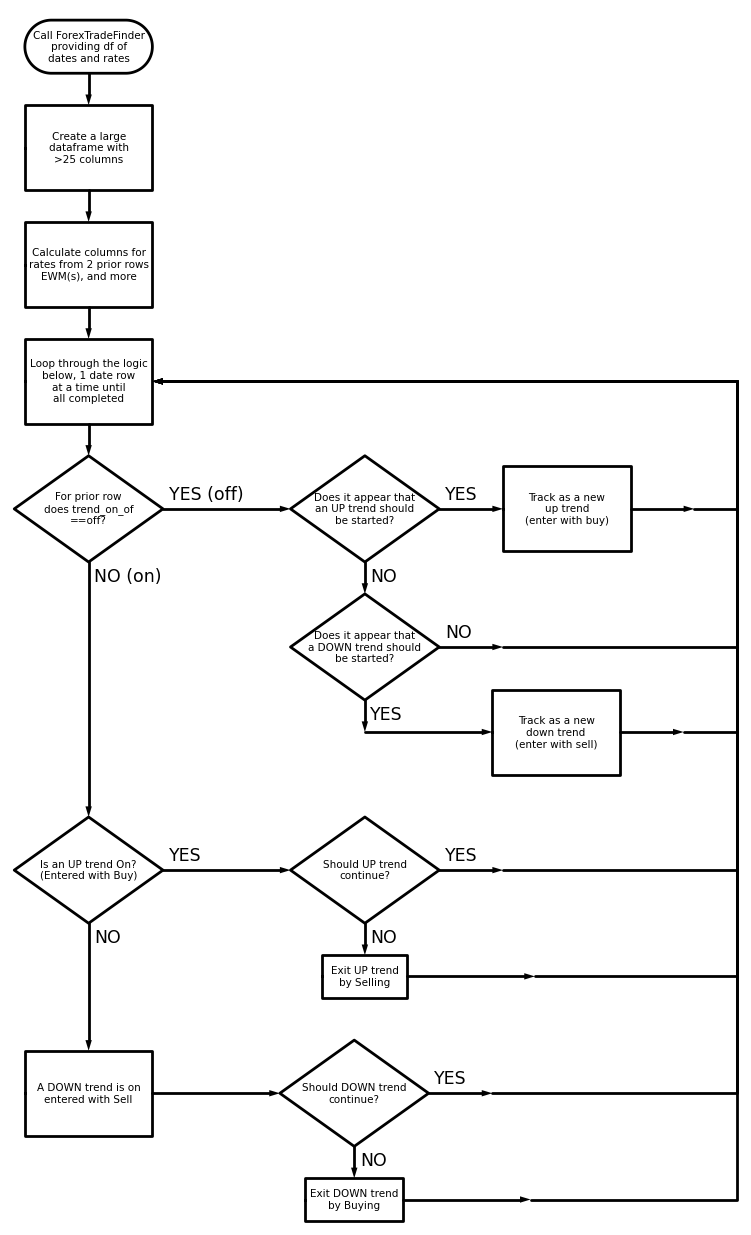

In [38]:

with schemdraw.Drawing() as d:
    
    d.config(fontsize=9, bgcolor="white")
    d+= Start().label('Call ForexTradeFinder\nproviding df of\ndates and rates')
    d+= Arrow().down(d.unit/4)
    d+= Process().label('Create a large\ndataframe with\n>25 columns')
    d+= Arrow().down(d.unit/4)
    d+= Process().label('Calculate columns for\nrates from 2 prior rows\nEWM(s), and more')
    d+= Arrow().down(d.unit/4)
    d+= (Loop := Process().label('Loop through the logic\nbelow, 1 date row\nat a time until\nall completed'))
    d+= Arrow().down(d.unit/4)
    d+= (Trend_off_on := Decision(w=3.5, h=2.5, E='YES (off)', S='NO (on)').label('For prior row\ndoes trend_on_of\n==off?'))
    d+= Arrow().right(d.unit/1).at(Trend_off_on.E)
    d+= (Start_up_trend := Decision(w=3.5, h=2.5, S='NO', E='YES').label('Does it appear that\nan UP trend should\nbe started?'))
    d+= Arrow().right(d.unit/2).at(Start_up_trend.E)
    d+= Process().label('Track as a new\nup trend\n(enter with buy)')
    d+= Arrow().right(d.unit/2)
    d+= Wire('c', k=1, arrow='->').to(Loop.E)
    d+= Arrow().down(d.unit/4).at(Start_up_trend.S)
    d+= (Start_down_trend := Decision(w=3.5, h=2.5, E="NO", S="YES").label('Does it appear that\na DOWN trend should\nbe started?'))
    d+= Arrow().right(d.unit/2).at(Start_down_trend.E)
    d+= Wire('c', k=5.5, arrow='->').to(Loop.E)
    d+= Arrow().down(d.unit/4).at(Start_down_trend.S)
    d+= Arrow().right(d.unit)
    d+= Process().label('Track as a new\ndown trend\n(enter with sell)')
    d+= Arrow().right(d.unit/2)
    d+= Wire('c', k=1.25, arrow='->').to(Loop.E)
    d+= Arrow().down(2*d.unit).at(Trend_off_on.S)
    d+= (Is_up_trend := Decision(w=3.5, h=2.5, E="YES", S="NO").label('Is an UP trend On?\n(Entered with Buy)'))
    d+= Arrow().right(d.unit/1).at(Is_up_trend.E)
    d+= (Should_up_cont := Decision(w=3.5, h=2.5, S="NO", E="YES").label('Should UP trend\ncontinue?'))
    d+= Arrow().right(d.unit/2)
    d+= Wire('c', k=5.5, arrow='->').to(Loop.E)
    d+= Arrow().down(d.unit/4).at(Should_up_cont.S)
    d+= (Exit_up := Process(w=2, h=1).label('Exit UP trend\nby Selling'))
    d+= Arrow().right(d.unit/1).at(Exit_up.E)
    d+= Wire('c', k=4.75, arrow='->').to(Loop.E)
    d+= Arrow().down(d.unit/1).at(Is_up_trend.S)
    d+= (Down_is_on := Process(w=3, h=2).label('A DOWN trend is on\nentered with Sell'))
    d+= Arrow().right(d.unit/1).at(Down_is_on.E)
    d+= (Should_down_cont := Decision(w=3.5, h=2.5, S="NO", E="YES").label('Should DOWN trend\ncontinue?'))
    d+= Arrow().right(d.unit/2)
    d+= Wire('c', k=5.75, arrow='->').to(Loop.E)
    d+= Arrow().down(d.unit/4).at(Should_down_cont.S)
    d+= (Exit_down := Process(w=2.3, h=1).label('Exit DOWN trend\nby Buying'))
    d+= Arrow().right(d.unit/1).at(Exit_down.E)
    d+= Wire('c', k=4.85, arrow='->').to(Loop.E)
    
d.save("flowchart.png")

#### One tunable parameter for the 'ForexTradeFinder' function is the span chosen for the exponential weighted mean support line.  It appears that different currencies may have different volatility frequencies (?), and the best choice of this parameter (EWM_span) will be different for different currencies.  (Admitedly don't fully understand this.)  Screened 16 or more span values for each of the 5 currencies in prior code notebooks (screening not all shown here), and a summary of the findings from that screen are shown in the next code block below.
#### In summary, the optimal values of the EWM_span parameter chosen for the 5 different currencies (each paired with USD) are the following: Euro = 7 day ;  Yen = 6 day ;  Pound = 17 day ;  Australian Dollar = 5 day ;  Swiss Franc = 16 day

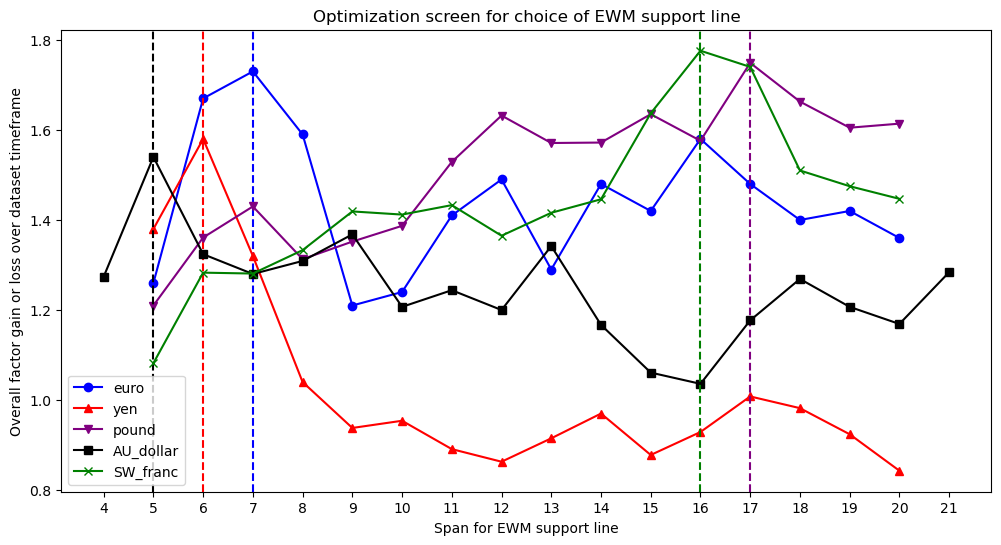

In [39]:
# EWM_span optimization screening data obtained from work in previous code notebooks

screen_df = pd.DataFrame(columns=['span','euro', 'yen', 'pound', 'AU_dollar', 'SW_franc'])
screen_df['span'] = np.arange(4,22)
screen_df['euro'] = [np.nan, 1.26, 1.67, 1.73, 1.59, 1.21, 1.24, 1.41, 1.49, 1.29, 1.48, 1.42, 1.58,
                               1.48, 1.40, 1.42, 1.36, np.nan]
screen_df['yen'] = [np.nan, 1.38, 1.58, 1.32, 1.04, 0.938, 0.954, 0.891, 0.863, 0.915, 0.970, 0.878,
                               0.929, 1.008, 0.982, 0.924, 0.843, np.nan]
screen_df['pound'] = [np.nan, 1.21, 1.361, 1.430, 1.313, 1.352, 1.387, 1.529, 1.632, 1.571, 1.572,
                               1.635, 1.576, 1.749, 1.663, 1.605, 1.614, np.nan]
screen_df['AU_dollar'] = [1.274, 1.540, 1.324, 1.280, 1.309, 1.368, 1.207, 1.244, 1.2, 1.342, 1.167,
                               1.061, 1.036, 1.177, 1.269, 1.207, 1.169, 1.284]
screen_df['SW_franc'] = [np.nan, 1.082, 1.283, 1.281, 1.333, 1.419, 1.412, 1.433, 1.365, 1.416, 1.446,
                                 1.637, 1.776, 1.740, 1.510, 1.475, 1.447, np.nan]

fig5, ax5 = plt.subplots(1,1, figsize = (12,6))
ax5.plot(screen_df['span'], screen_df['euro'], marker="o", c="b", label='euro')
ax5.axvline(7, c="b", linestyle="--")
ax5.plot(screen_df['span'], screen_df['yen'], marker="^", c="r", label='yen')
ax5.axvline(6, c="r", linestyle="--")
ax5.plot(screen_df['span'], screen_df['pound'], marker="v", c="purple", label='pound')
ax5.axvline(17, c="purple", linestyle="--")
ax5.plot(screen_df['span'], screen_df['AU_dollar'], marker="s", c="k", label='AU_dollar')
ax5.axvline(5, c="k", linestyle="--")
ax5.plot(screen_df['span'], screen_df['SW_franc'], marker="x", c="green", label='SW_franc')
ax5.axvline(16, c="green", linestyle="--")

ax5.set_xticks(np.arange(4,22))
ax5.set_ylabel("Overall factor gain or loss over dataset timeframe")
ax5.set_xlabel("Span for EWM support line")
ax5.set_title("Optimization screen for choice of EWM support line")
plt.legend(loc='lower left')
plt.savefig("FTF EWM span optimization.png")
plt.show()



#### The function 'ForexTradeFinder' is applied in the 5 code blocks below, to the five different currencies for the timeframe of the dataset that we have, using the optimized choices of EWM_span for each currency.  The function provides one example timeseries plot over a specified short timeframe (about 4 to 6 months gives a readable plot -- longer times are too compressed), but it does calculations on all the data available to determine overall gain or loss, the distribution of individual trade gain or loss, and the duration of individual trades.

Trading in currency =  Euro
Minimum to start trend =  2
EWM span =  7
Date range for full dataset = 2004-01-02 to 2022-12-05
Number of trades in full date range =  595
Overall gain/loss using this strategy for the full timeframe of the data =  1.67847
Example plot timeframe = 2004-01-01 to 2004-04-30
Plot filenames = Ts, Hist, Sct  FTF Euro MinForTrend2 EWM7 2004-01-01 to 2004-04-30.png


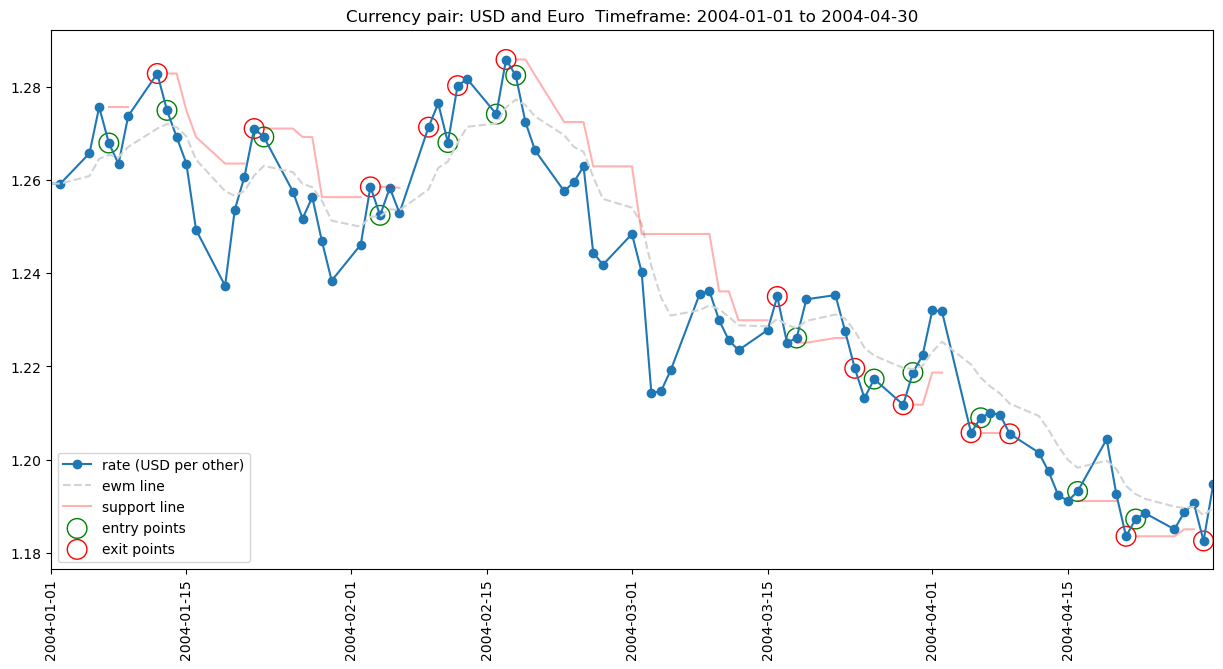

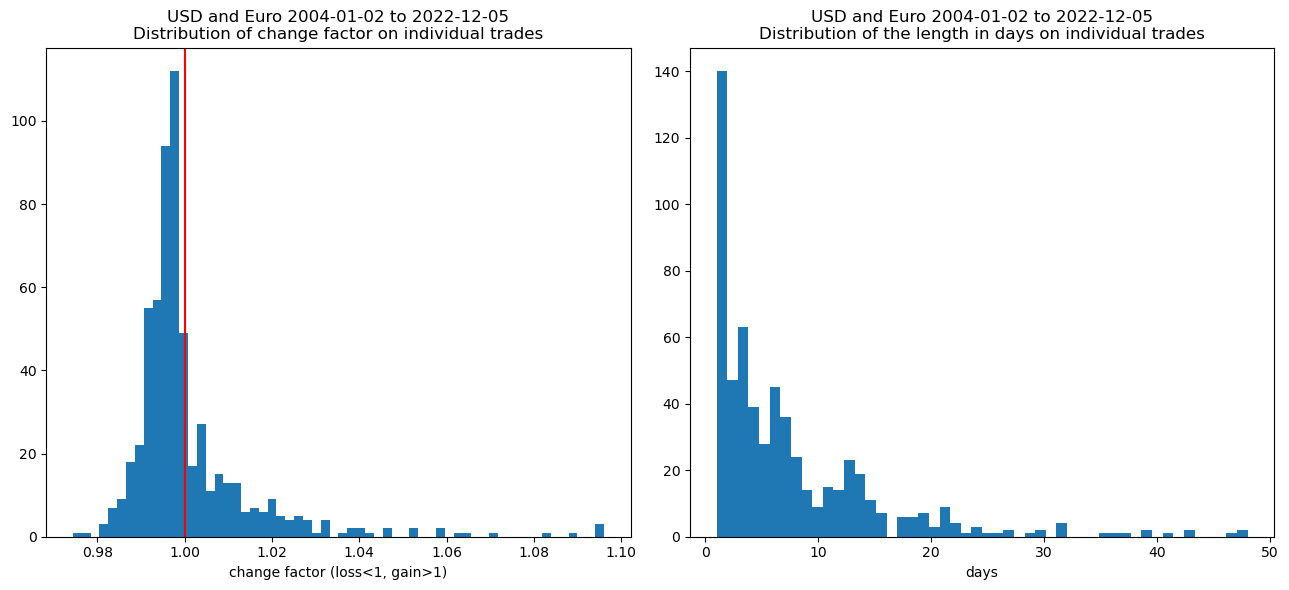

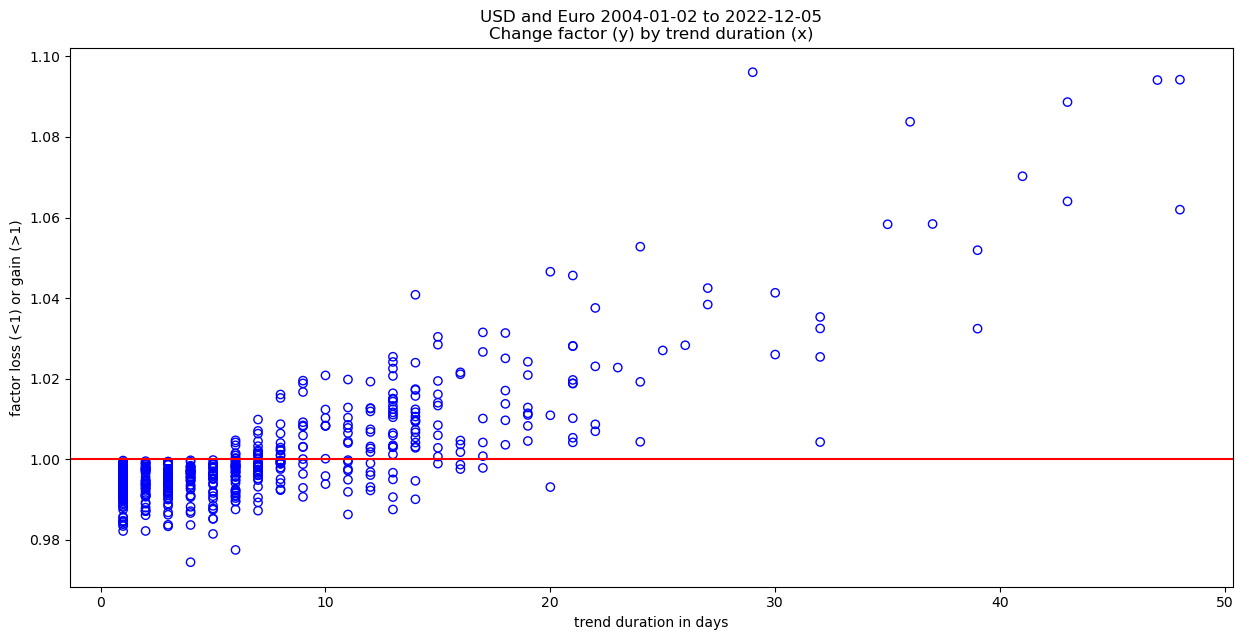

In [40]:
ForexTradeFinder(a_dataframe = forex_rates[['date', 'euro_to_usd']],
            CurrencyName = 'Euro',
            StartPlotDate = pd.to_datetime("2004-01-01"),
            EndPlotDate = pd.to_datetime("2004-04-30"),
            MinForTrend = 2,
            EWM_span = 7)

Trading in currency =  Yen
Minimum to start trend =  2
EWM span =  6
Date range for full dataset = 2004-01-02 to 2022-12-05
Number of trades in full date range =  559
Overall gain/loss using this strategy for the full timeframe of the data =  1.57065
Example plot timeframe = 2004-01-01 to 2004-04-30
Plot filenames = Ts, Hist, Sct  FTF Yen MinForTrend2 EWM6 2004-01-01 to 2004-04-30.png


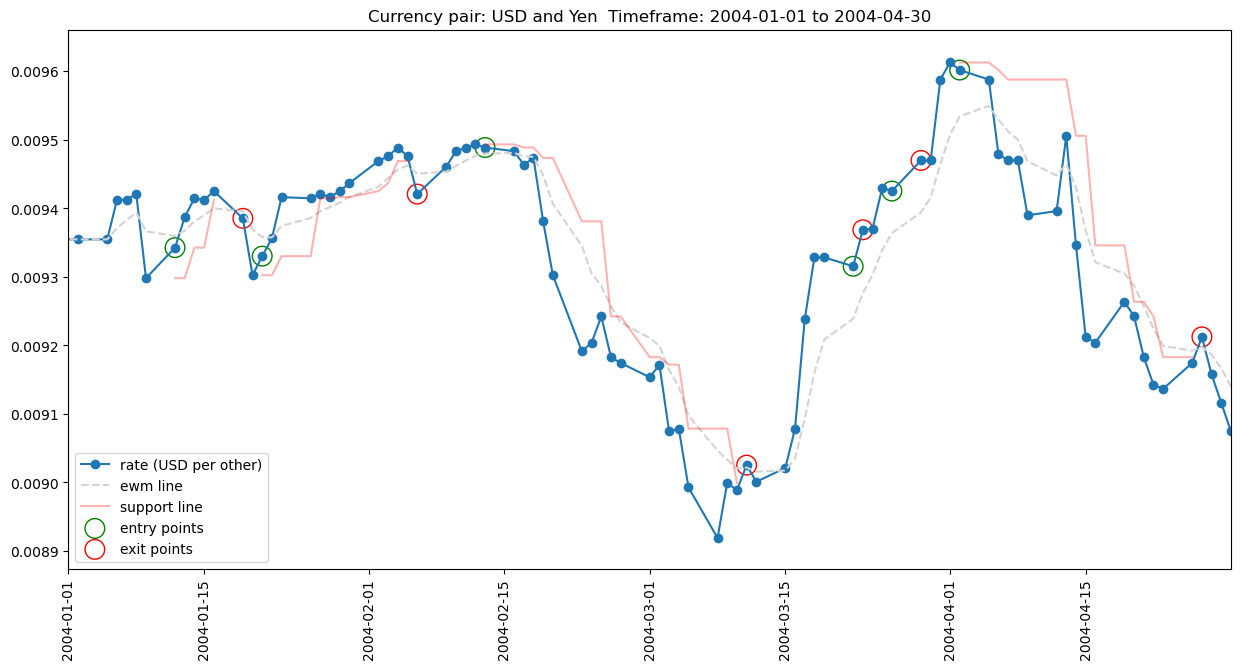

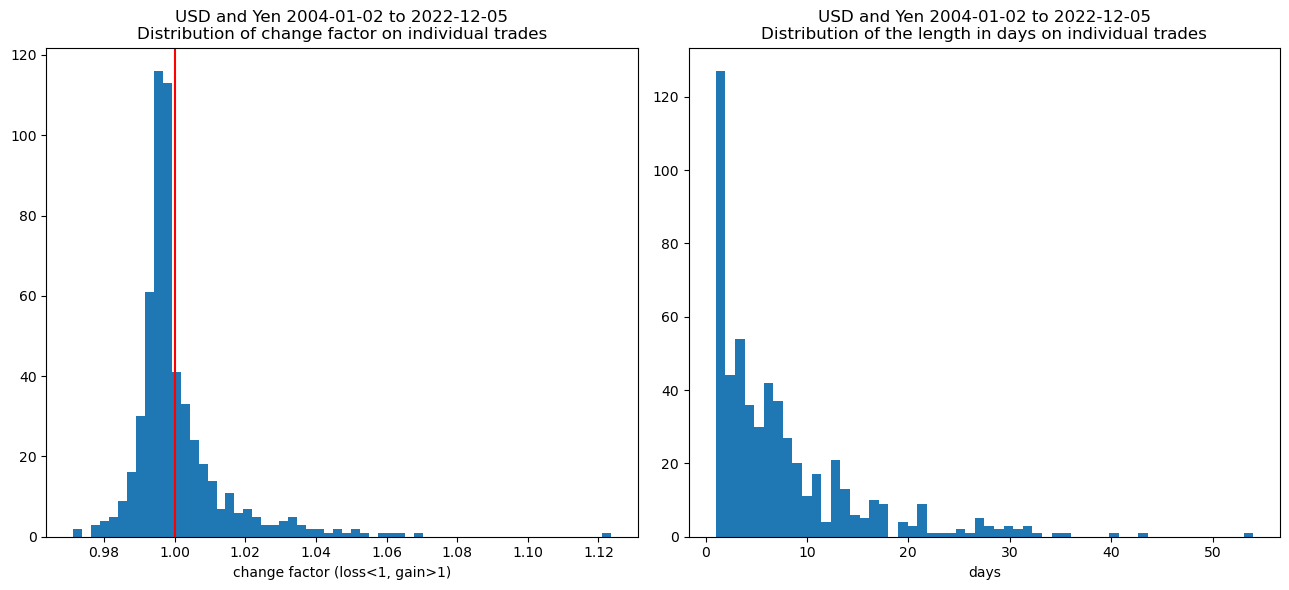

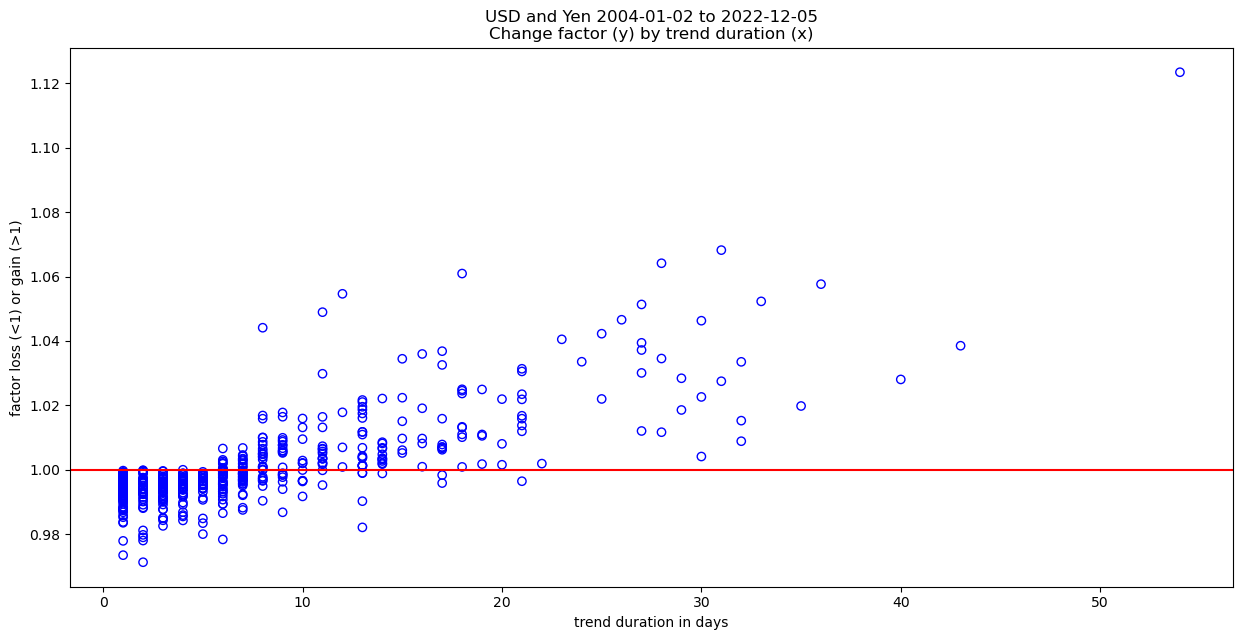

In [41]:
ForexTradeFinder(a_dataframe = forex_rates[['date', 'japanese_yen_to_usd']],
            CurrencyName = 'Yen',
            StartPlotDate = pd.to_datetime("2004-01-01"),
            EndPlotDate = pd.to_datetime("2004-04-30"),
            MinForTrend = 2, 
            EWM_span=6)

Trading in currency =  Pound
Minimum to start trend =  2
EWM span =  17
Date range for full dataset = 2004-01-02 to 2022-12-05
Number of trades in full date range =  602
Overall gain/loss using this strategy for the full timeframe of the data =  1.70925
Example plot timeframe = 2004-01-01 to 2004-04-30
Plot filenames = Ts, Hist, Sct  FTF Pound MinForTrend2 EWM17 2004-01-01 to 2004-04-30.png


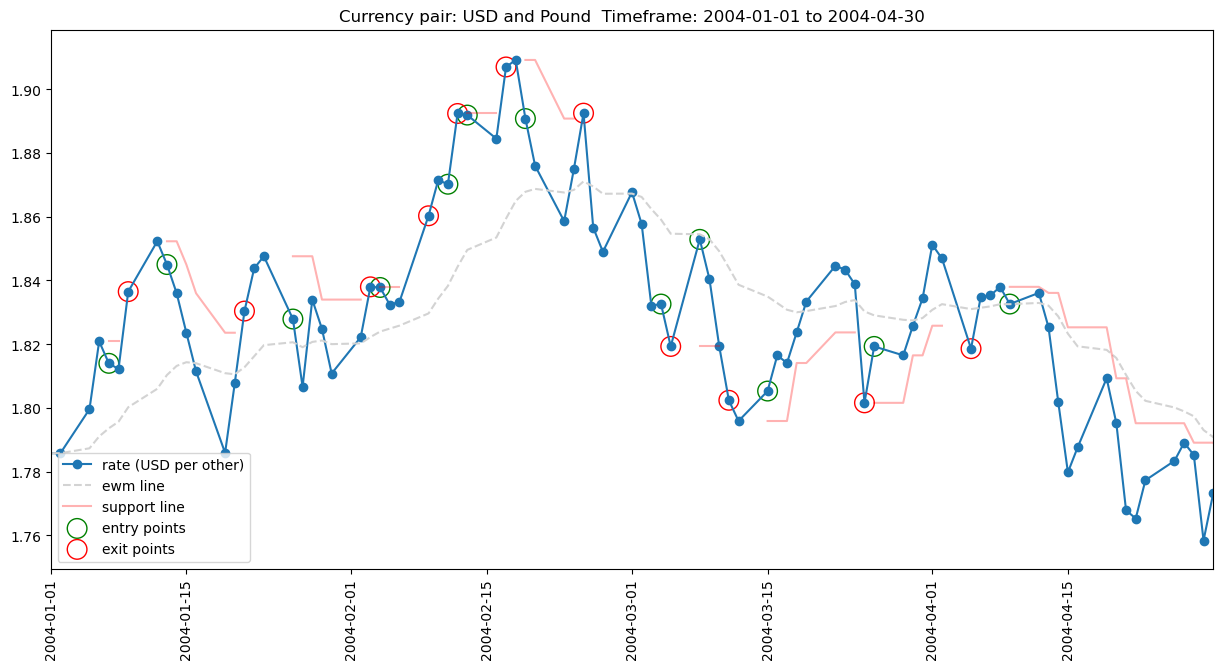

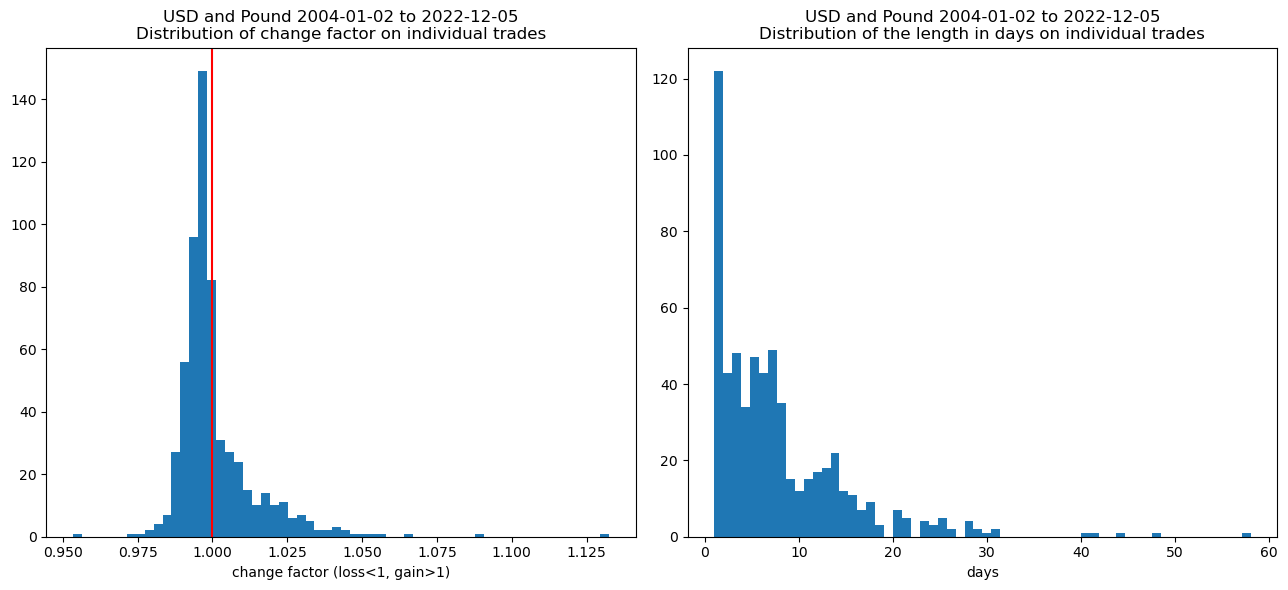

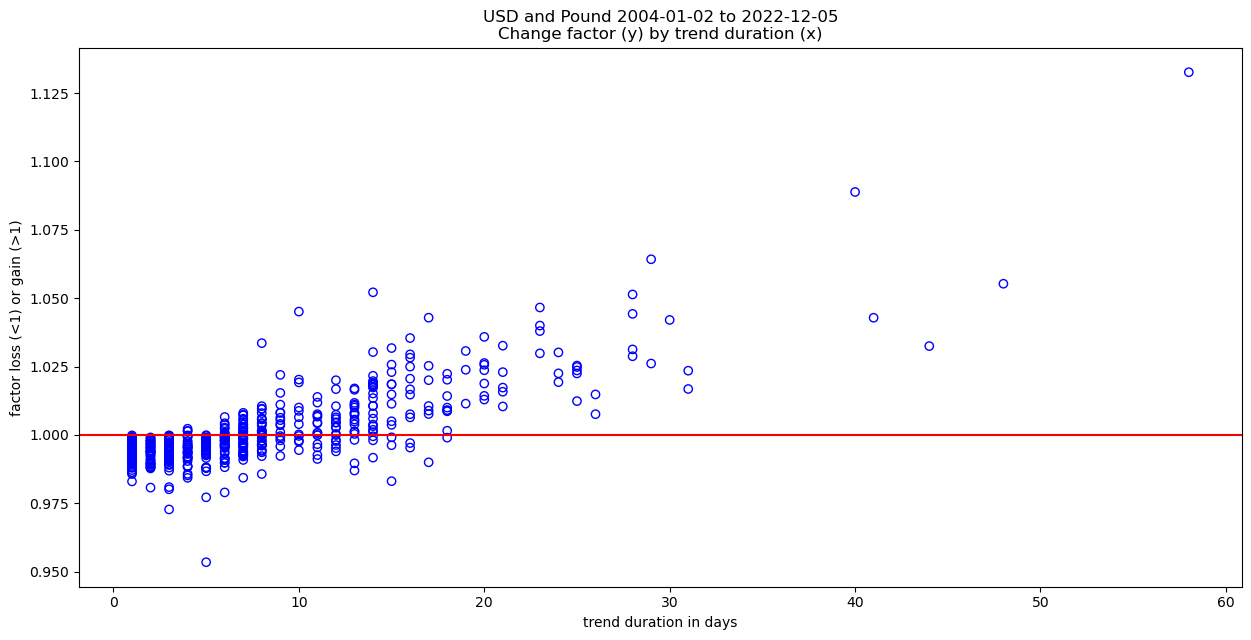

In [42]:
ForexTradeFinder(a_dataframe = forex_rates[['date', 'uk_pound_to_usd']],
            CurrencyName = 'Pound',
            StartPlotDate = pd.to_datetime("2004-01-01"),
            EndPlotDate = pd.to_datetime("2004-04-30"),
            MinForTrend = 2,
            EWM_span = 17)

Trading in currency =  Australian Dollar
Minimum to start trend =  2
EWM span =  5
Date range for full dataset = 2004-01-02 to 2022-12-05
Number of trades in full date range =  547
Overall gain/loss using this strategy for the full timeframe of the data =  1.51583
Example plot timeframe = 2004-01-01 to 2004-04-30
Plot filenames = Ts, Hist, Sct  FTF Australian Dollar MinForTrend2 EWM5 2004-01-01 to 2004-04-30.png


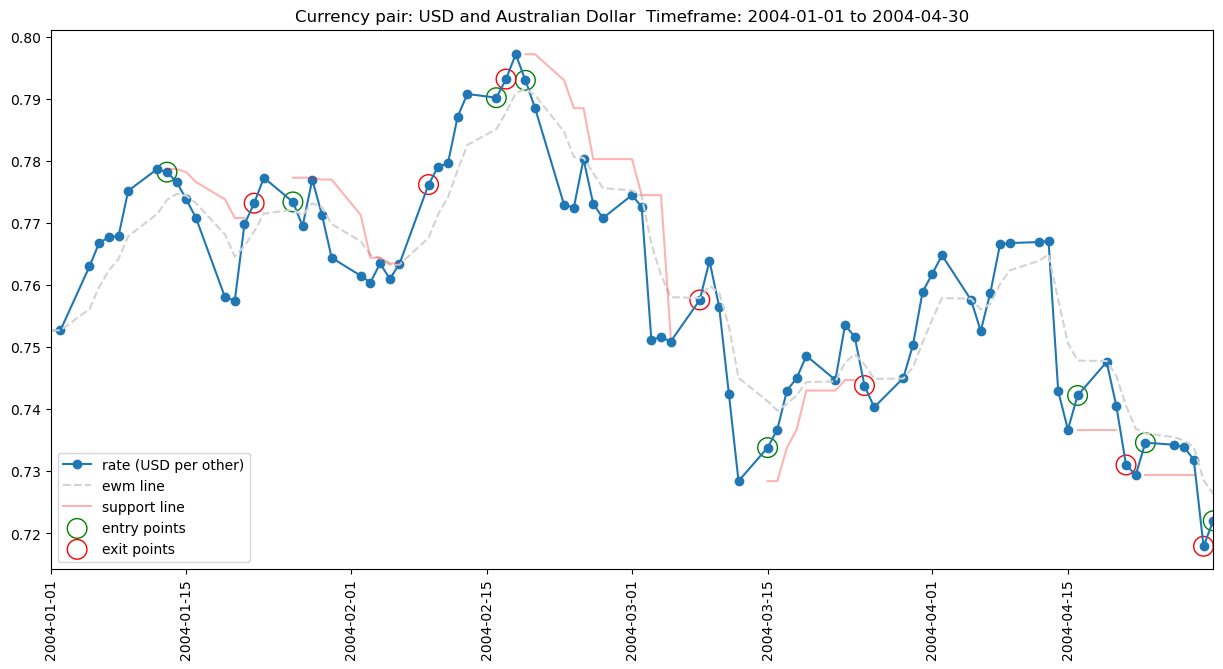

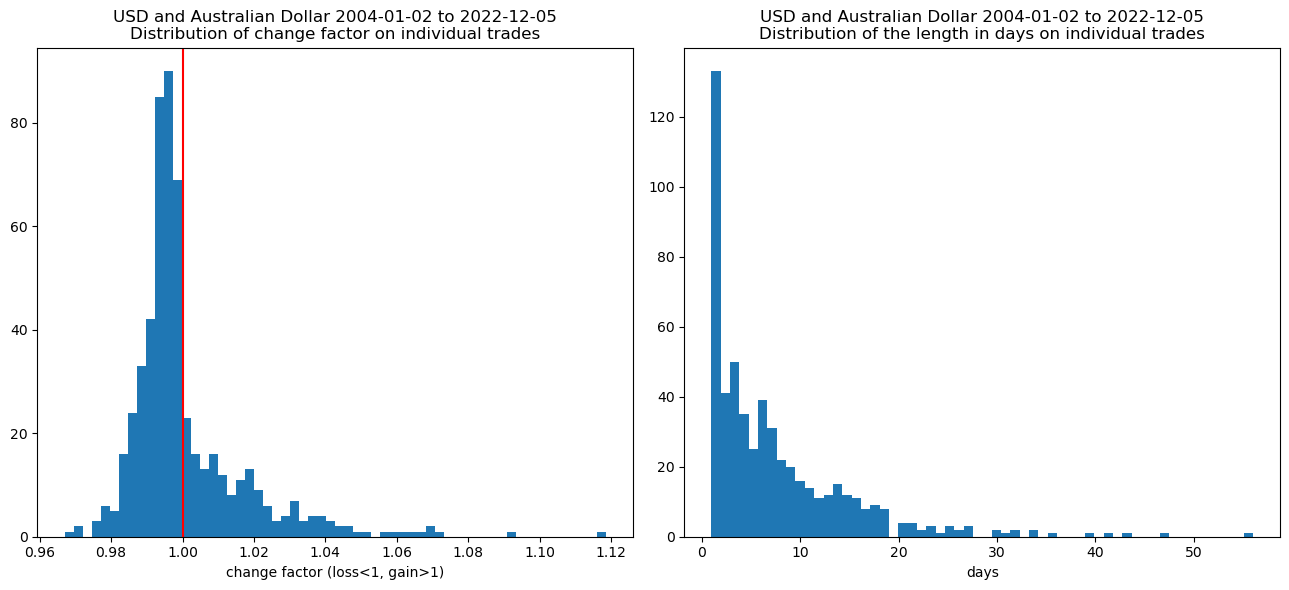

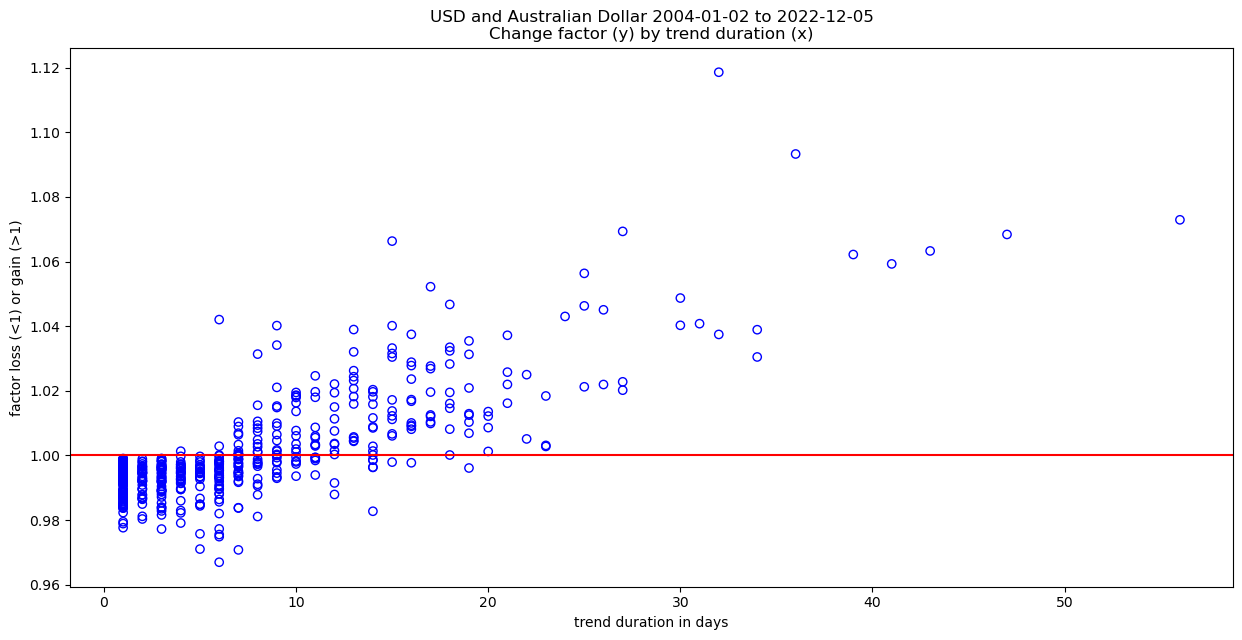

In [43]:
ForexTradeFinder(a_dataframe = forex_rates[['date', 'australian_dollar_to_usd']],
            CurrencyName = 'Australian Dollar',
            StartPlotDate = pd.to_datetime("2004-01-01"),
            EndPlotDate = pd.to_datetime("2004-04-30"),
            MinForTrend = 2,
            EWM_span=5)

Trading in currency =  Swiss Franc
Minimum to start trend =  2
EWM span =  16
Date range for full dataset = 2004-01-02 to 2022-12-05
Number of trades in full date range =  600
Overall gain/loss using this strategy for the full timeframe of the data =  1.72681
Example plot timeframe = 2004-01-01 to 2004-04-30
Plot filenames = Ts, Hist, Sct  FTF Swiss Franc MinForTrend2 EWM16 2004-01-01 to 2004-04-30.png


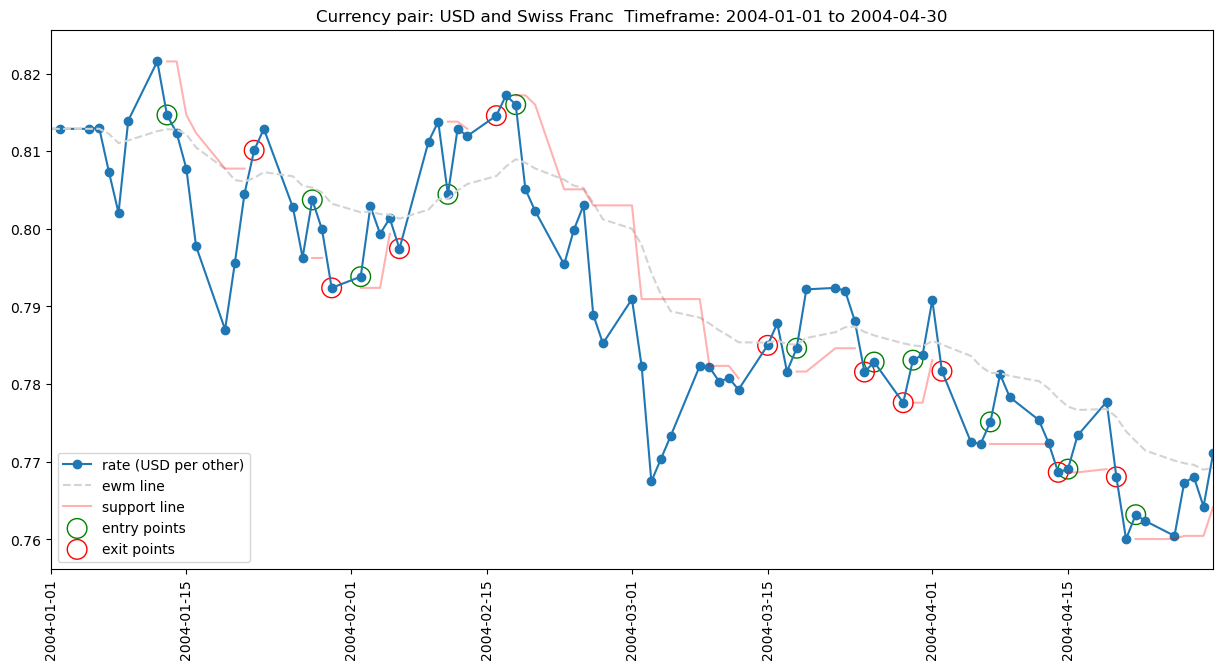

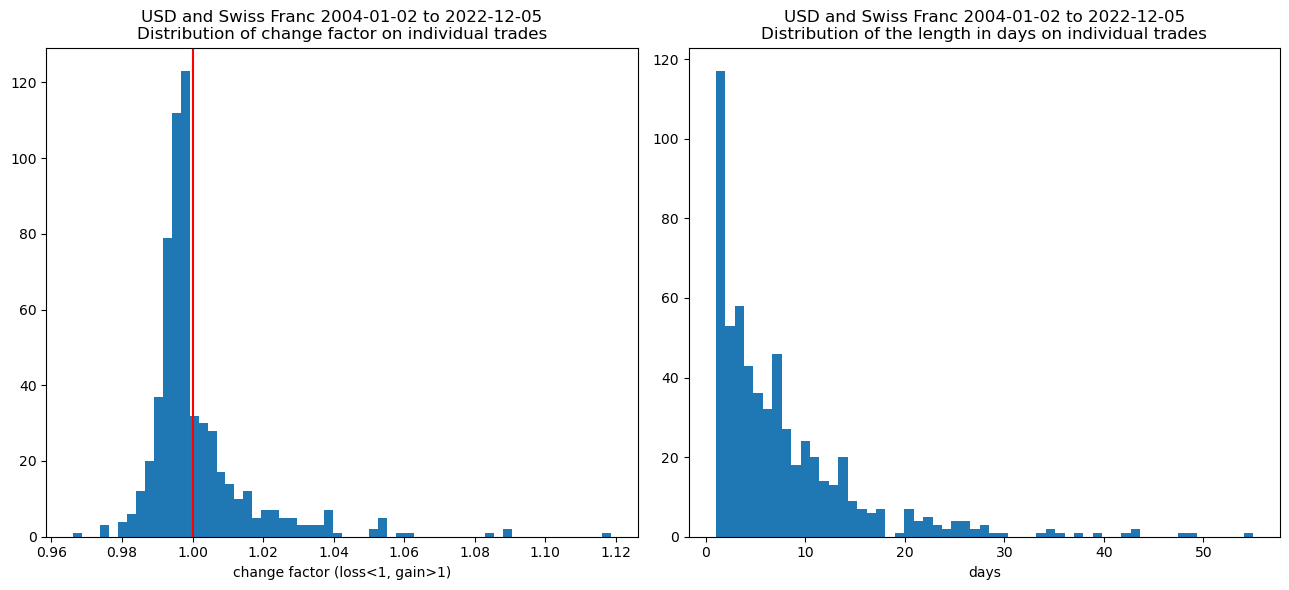

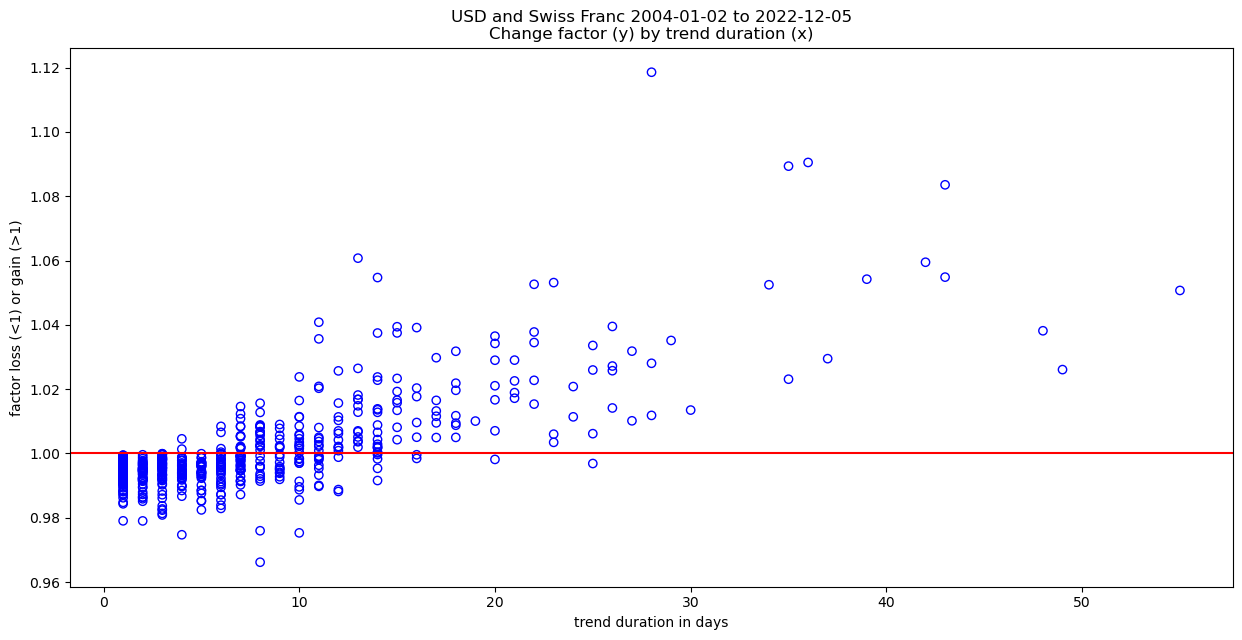

In [44]:
ForexTradeFinder(a_dataframe = forex_rates[['date', 'swiss_franc_to_usd']],
            CurrencyName = 'Swiss Franc',
            StartPlotDate = pd.to_datetime("2004-01-01"),
            EndPlotDate = pd.to_datetime("2004-04-30"),
            MinForTrend = 2,
            EWM_span = 16)